# Предсказание успешности стартапов

## Описание проекта

В данном проекте мы разрабатываем модель для предсказания успешности стартапа (закроется или продолжит действовать). Для этого используются исторические данные о стартапах за период с 1970 по 2018 год. Датасет состоит из двух частей: тренировочного набора данных (около 53 000 записей) и тестового набора данных (около 13 000 записей).

### Данные

**Тренировочный набор данных (kaggle_startups_train_01.csv)**

Тренировочный набор содержит информацию о 53 000 стартапах, включая их статус (целевой признак), указывающий на то, закрылся стартап или продолжает действовать.

**Тестовый набор данных (kaggle_startups_test_01.csv)**

Тестовый набор содержит информацию о 13 000 стартапах. Наша задача - предсказать значение 'status' для каждого стартапа из этого датасета.

**Пример предсказаний (kaggle_startups_sample_submit_01.csv)**

Этот файл содержит пример предсказаний в правильном формате. Он включает в себя два столбца: `name` (название стартапа) и `status` (предсказанный статус: 'operating' или 'closed').

### Описание полей данных

- `name` - Название стартапа
- `category_list` - Список категорий, к которым относится стартап
- `funding_total_usd` - Общая сумма финансирования в USD
- `status` - Статус стартапа (закрыт или действующий)
- `country_code` - Код страны
- `state_code` - Код штата
- `region` - Регион
- `city` - Город
- `funding_rounds` - Количество раундов финансирования
- `founded_at` - Дата основания
- `first_funding_at` - Дата первого раунда финансирования
- `last_funding_at` - Дата последнего раунда финансирования
- `closed_at` - Дата закрытия стартапа (если применимо)
- `lifetime` - Время существования стартапа в днях

### Цель проекта

Цель проекта - построить модель, которая будет предсказывать статус стартапа на основе предоставленных данных. Мы будем использовать различные методы машинного обучения для достижения этой цели и оценивать качество модели на тестовом наборе данных.

### Шаги выполнения проекта

1. Загрузка и предобработка данных
2. Анализ данных и визуализация
3. Построение и оценка модели
4. Применение модели к тестовому набору данных
5. Оформление результатов


## Загрузка данных 

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import missingno as msno 
#Импортируем основные библиотеки для работы с данными 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Импорт phik и SHAP и mlxtend
import phik
from phik import phik_matrix, report
from phik.report import plot_correlation_matrix
import shap

#Импорт препроцессинга 
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)

from sklearn.metrics import (
    f1_score, 
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay)

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

#Импорт моделей
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
import category_encoders as ce

import optuna
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, f1_score, precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, f1_score, classification_report
from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import SMOTE

import optuna
from optuna.integration import OptunaSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [5]:
# Загрузка тренировочного набора данных с парсированием дат
df_train = pd.read_csv(
    '/Users/chajartem/Yandex_Praktikum_DS2024_datasetst/startups-operations-close-predictions-m1-31ds/kaggle_startups_train_27042024.csv',
    parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
)

# Загрузка тестового набора данных с парсированием дат
df_test = pd.read_csv(
    '/Users/chajartem/Yandex_Praktikum_DS2024_datasetst/startups-operations-close-predictions-m1-31ds/kaggle_startups_test_27042024.csv',
    parse_dates=['founded_at', 'first_funding_at', 'last_funding_at']
)

- **Загрузка данных**: Были загружены тренировочный и тестовый наборы данных, содержащие информацию о стартапах с 1970 по 2018 год.
- **Парсирование дат**: Поля с датами (`founded_at`, `first_funding_at`, `last_funding_at`, `closed_at` для тренировочного набора и аналогичные поля без `closed_at` для тестового) были преобразованы для удобства работы с временными интервалами.

### Тренировочный датасет 

In [8]:
#pd.set_option('display.max_rows', None)

In [9]:
#Информация о тренировочном датасете
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52513 non-null  object        
 1   category_list      50049 non-null  object        
 2   funding_total_usd  42445 non-null  float64       
 3   status             52514 non-null  object        
 4   country_code       47013 non-null  object        
 5   state_code         45752 non-null  object        
 6   region             46156 non-null  object        
 7   city               46156 non-null  object        
 8   funding_rounds     52514 non-null  int64         
 9   founded_at         52514 non-null  datetime64[ns]
 10  first_funding_at   52514 non-null  datetime64[ns]
 11  last_funding_at    52514 non-null  datetime64[ns]
 12  closed_at          4915 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [10]:
#HEAD первых 5 строк в тренировочных данных 
df_train.head(5)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,NaT


In [11]:
#Названия столбцов
df_train.columns 

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'closed_at'],
      dtype='object')

*`Названия колонок оформленые верно!`*

### Тестовывый датасет 

In [14]:
#Информация о тестовом датасете
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   founded_at         13125 non-null  datetime64[ns]
 9   first_funding_at   13125 non-null  datetime64[ns]
 10  last_funding_at    13125 non-null  datetime64[ns]
 11  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(6)
memory usage: 1.2+ MB


In [15]:
#Названия столбцов
df_test.columns 

Index(['name', 'category_list', 'funding_total_usd', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'lifetime'],
      dtype='object')

*`Названия колонок оформленые верно!`*

In [17]:
#HEAD первых 5 строк в тестовых данных 
df_test.head(5)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,6209


**Обзор тренировочного датасета**

- **Количество записей**: 52,514
- **Количество признаков**: 13
- **Типы данных**:
  - **Числовые**: `funding_total_usd`, `funding_rounds`
  - **Категориальные**: `name`, `category_list`, `status`, `country_code`, `state_code`, `region`, `city`
  - **Дата/время**: `founded_at`, `first_funding_at`, `last_funding_at`, `closed_at`

**Основные наблюдения по тренировочному датасету**

- **Пропущенные значения**:
  - Наличие пропущенных значений в полях `category_list`, `funding_total_usd`, `country_code`, `state_code`, `region`, `city`
  - Большинство записей не имеет данных о дате закрытия (`closed_at`), что может указывать на продолжающуюся операционную деятельность стартапов

**Обзор тестового датасета**

- **Количество записей**: 13,125
- **Количество признаков**: 12 (отсутствует `status`)

**Основные наблюдения по тестовому датасету**

- **Пропущенные значения**:
  - Присутствуют пропущенные значения в тех же полях, что и в тренировочном наборе

**Наблюдения по обоим датасетам**

- **Названия колонок**: Идентичны. 
- **Пропущенные значения и их обработка**: Требуется дополнительная обработка для устранения пробелов в данных. 


## Предобработка данных

### Тренировочный датасет 

In [21]:
#наличие явных дубликатов в тренировочных данных 
print(f' Дубликаты в тренировочном датасете: {df_train.duplicated().sum()}')

 Дубликаты в тренировочном датасете: 0


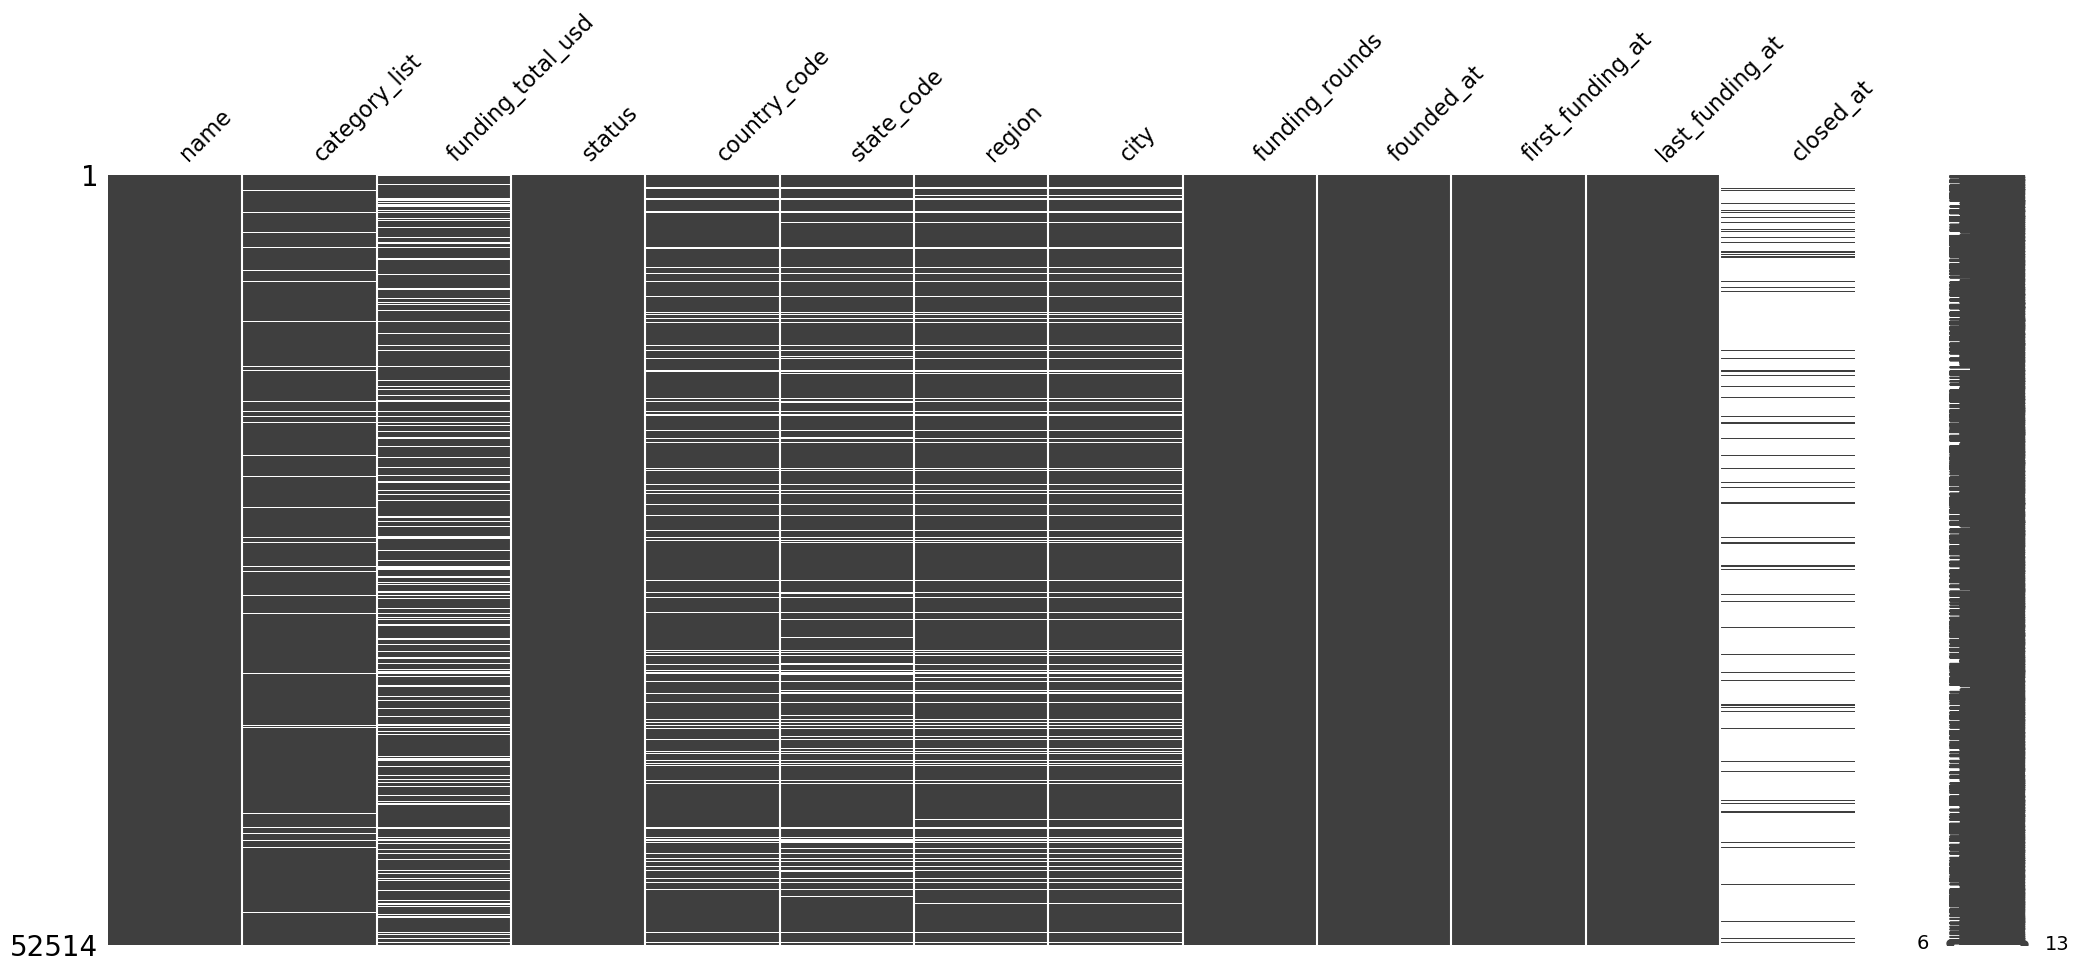

In [22]:
#Визуальзация пропусков MSNO 
msno.matrix(df_train);

In [23]:
#Количество пропусков 
df_train.isnull().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5501
state_code            6762
region                6358
city                  6358
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

- Колонка `closed_at` содержит пропуски для стартапов, которые продолжают действовать, так как у них нет даты закрытия. Таким образом, наличие пропуска в этой колонке означает, что стартап не закрылся.

- Для начала заполним столбец `closed_at` датой загрузски датасета `2018-01-01` чтобы закрыть пропуски. Поскольку в тестовом датасете есть колонка `lifetime`, мы синтезируем его в тренировочном датасете путем вычитания `closed_at` - `founded_at`. 

In [25]:
#заполним пропуски в closed_at датой выгрузки 
df_train['closed_at'] = df_train['closed_at'].fillna(pd.to_datetime('2018-01-01'))
                            
#определим новое значение lifetime 
df_train['lifetime'] = (df_train['closed_at'] - df_train['founded_at']).dt.days

Числове пропуски будем обрабатывать через **ИМПУТЕРЫ**. Поскольку категориальные данные имеют большое количество уникальных значений, их будем обрабатывать через TargetEncoder, поэтому предварительно ставим заглушки. 

In [27]:
#обзорная копия 
df_train_copy = df_train.copy()

In [28]:
#check 
df_train.isnull().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5501
state_code            6762
region                6358
city                  6358
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at                0
lifetime                 0
dtype: int64

In [29]:
#поставим заглушку Unknown
df_train['name'] = df_train['name'].fillna('Unknown')
df_train['category_list'] = df_train['category_list'].fillna('Unknown')
df_train['country_code'] = df_train['country_code'].fillna('Unknown')
df_train['state_code'] = df_train['state_code'].fillna('Unknown')
df_train['region'] = df_train['region'].fillna('Unknown')
df_train['city'] = df_train['city'].fillna('Unknown')


In [30]:
#check 
df_train.isnull().sum()

name                     0
category_list            0
funding_total_usd    10069
status                   0
country_code             0
state_code               0
region                   0
city                     0
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at                0
lifetime                 0
dtype: int64

***Данные готовы к дальнейшему анализу***

### Тестовый датасет 

In [33]:
#наличие явных дубликатов в тренировочных данных 
print(f' Дубликаты в тренировочном датасете: {df_test.duplicated().sum()}')

 Дубликаты в тренировочном датасете: 0


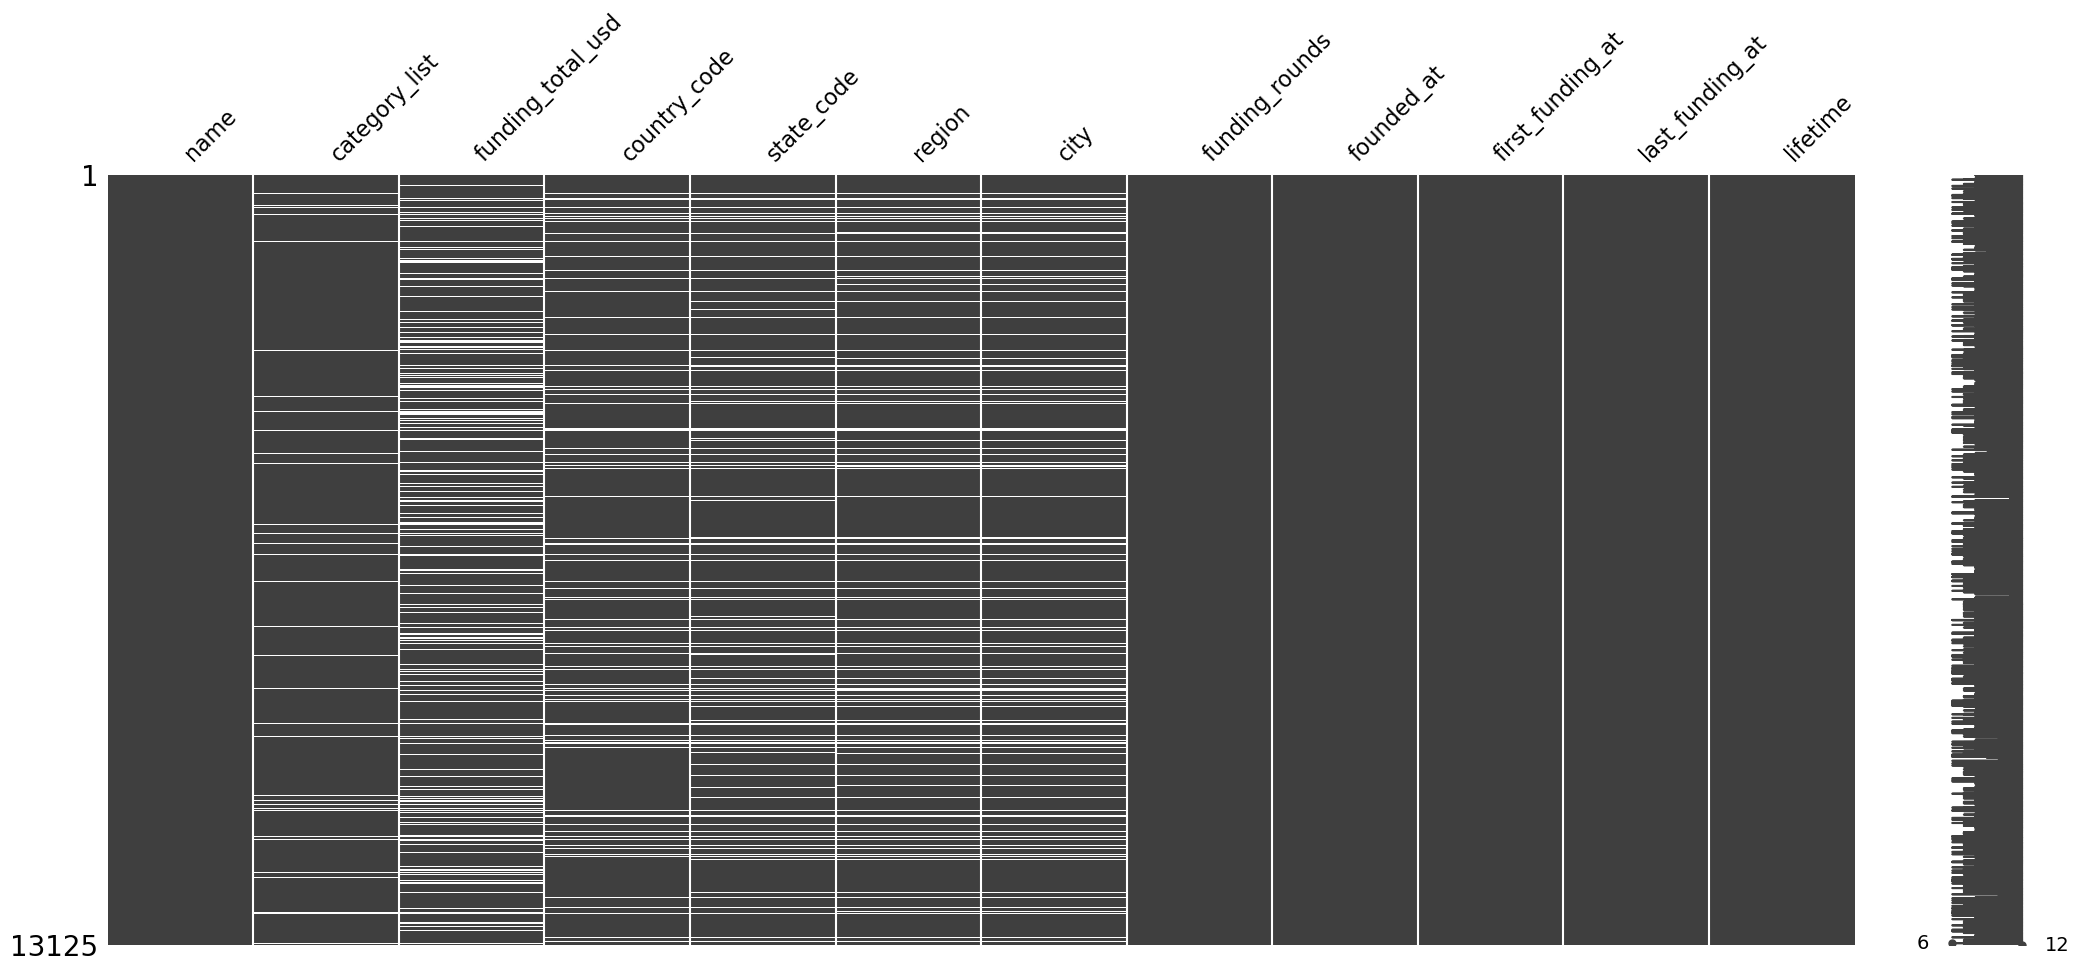

In [34]:
#Визуальзация пропусков MSNO 
msno.matrix(df_test);

In [35]:
#Количество пропусков 
df_test.isnull().sum()

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
founded_at              0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

In [36]:
#обзорная копия тестовых данных 
df_test_copy = df_test.copy()

In [37]:
#поставим заглушку Unknown
df_test['category_list'] = df_test['category_list'].fillna('Unknown')
df_test['country_code'] = df_test['country_code'].fillna('Unknown')
df_test['state_code'] = df_test['state_code'].fillna('Unknown')
df_test['region'] = df_test['region'].fillna('Unknown')
df_test['city'] = df_test['city'].fillna('Unknown')

In [38]:
#check 
df_test.isnull().sum()

name                    0
category_list           0
funding_total_usd    2578
country_code            0
state_code              0
region                  0
city                    0
funding_rounds          0
founded_at              0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

***Тестовые данные готовы к дальнейшему анализу***

## EDA 

### Обзор тренировочных данных 

In [42]:
df_train.head(5)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,2018-01-01,2923
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383
3,Sancilio and Company,Health Care,22250000.0,operating,Unknown,Unknown,Unknown,Unknown,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,5114
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,2018-01-01,2650


Смотрим категории. Категории имеют интересный формат с разделителем, чтобы проанализировать, воспользумеся get_dummies и посмотрим какие категории самые популярные. 

In [44]:
def visualize_top_categories(df, column_name, top_n=10):
    # Преобразование категорий в числовой формат
    category_dummies = df[column_name].str.get_dummies(sep='|')
    # Подсчет суммарного количества категорий
    category_counts = category_dummies.sum().sort_values(ascending=False)
    # ТОП популярных категорий
    top_categories = category_counts.head(top_n)

    # Визуализация
    plt.figure(figsize=(10, 4))
    sns.barplot(x=top_categories.values, y=top_categories.index)
    plt.title(f'Топ-{top_n} популярных категорий')
    plt.xlabel('Количество')
    plt.ylabel('Категория')
    plt.show()


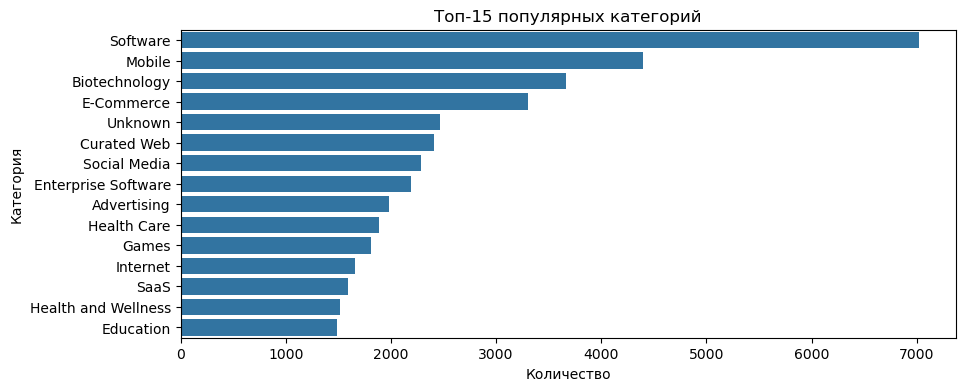

In [45]:
# Визуализация 
visualize_top_categories(df_train, 'category_list', top_n=15)

График показывает, что категория "Software" является самой популярной, с наибольшим количеством стартапов, за ней следуют "Mobile", "Biotechnology", "E-Commerce" и другие. Обратим внимание на заглушку Unknown - пропущенных данных в данной категории достаточно много, что говорит о сущесвенной потере в пропущенных значениях. 

In [47]:
def geo_top_categories(df, columns, top_n=15):
    for column in columns:
        # Подсчет количества уникальных значений
        value_counts = df[column].value_counts().head(top_n)
        
        # Визуализация
        plt.figure(figsize=(12, 4))
        sns.barplot(x=value_counts.values, y=value_counts.index)
        plt.title(f'Топ-{top_n} популярных значений в {column}')
        plt.xlabel('Количество')
        plt.ylabel(column)
        plt.show()


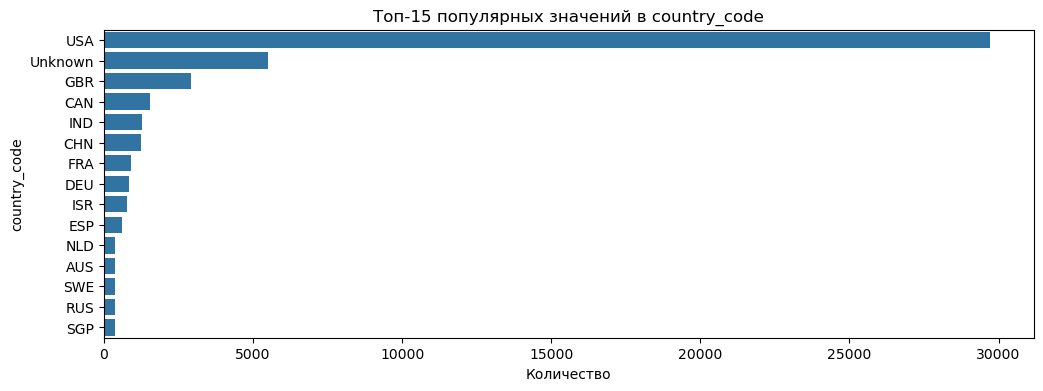

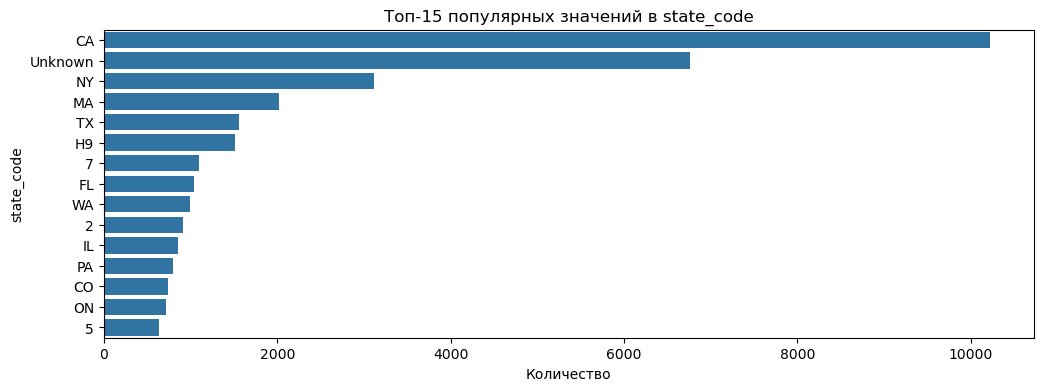

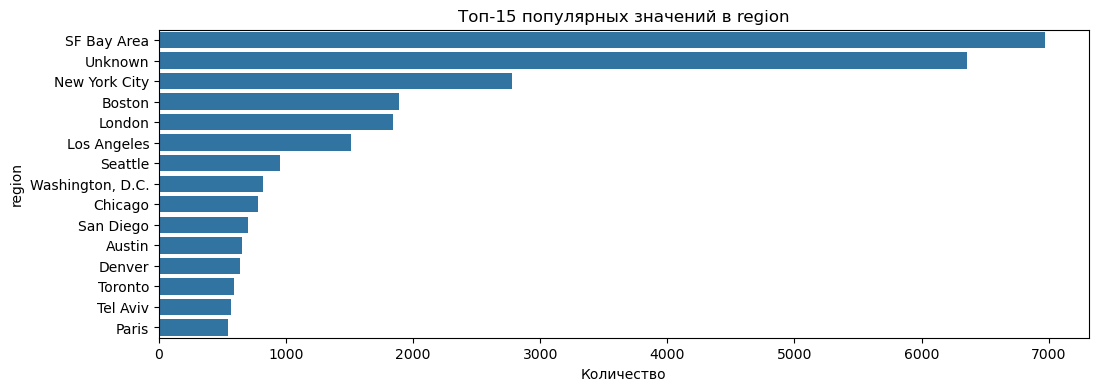

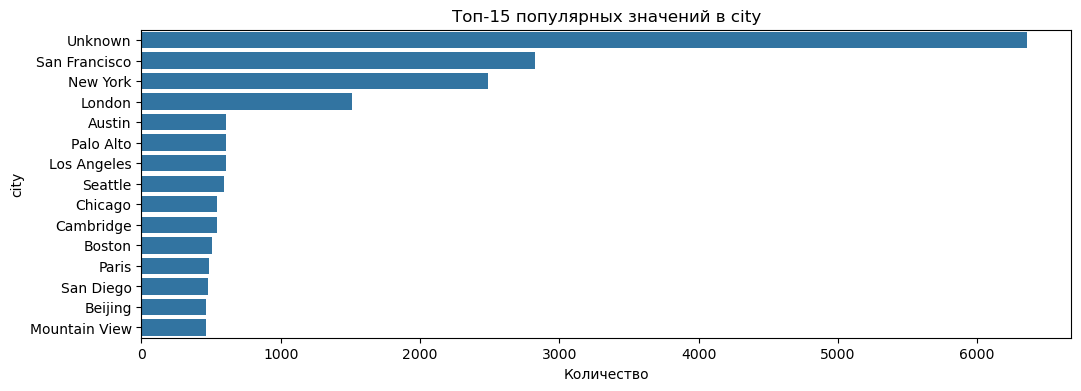

In [48]:
geo_columns = ['country_code', 'state_code', 'region', 'city']
geo_top_categories(df_train, geo_columns, top_n=15)

Лидером по количеству стартапов является США, а так же соответствующие города из этой страны. 

In [50]:
def visualize_date_columns(df, columns):

    for column in columns:
        plt.figure(figsize=(12, 4))
        sns.histplot(df[column].dropna(), kde=True, bins=50)
        plt.title(f'Распределение {column}')
        plt.xlabel('Дата')
        plt.ylabel('Количество')
        plt.show()

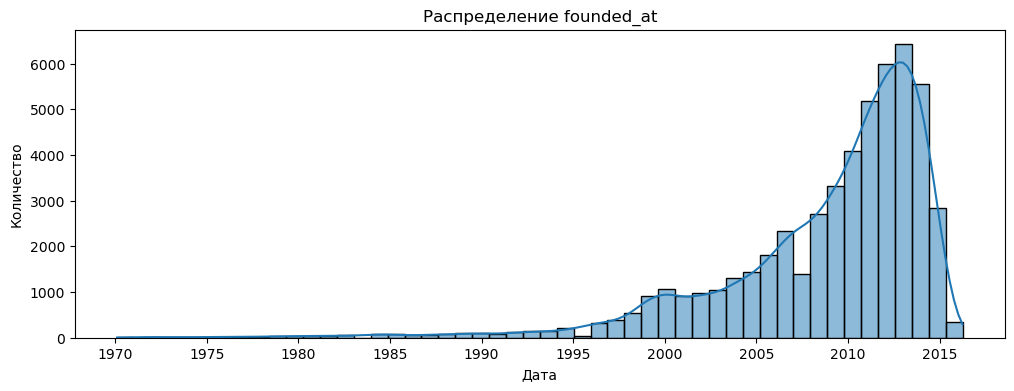

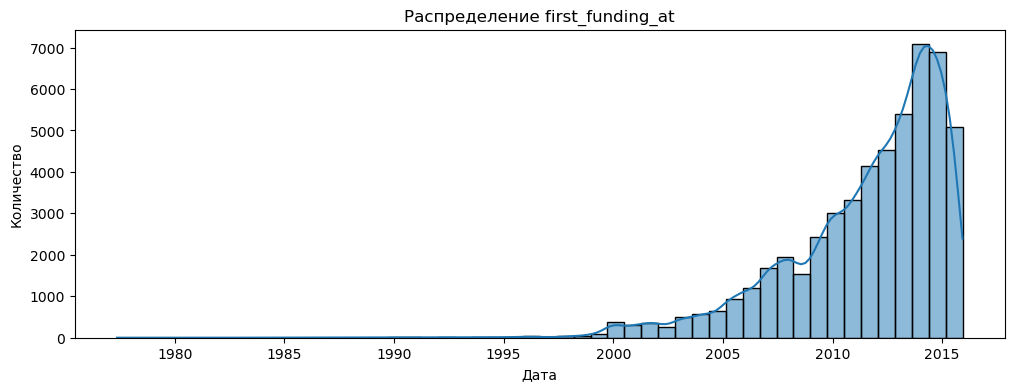

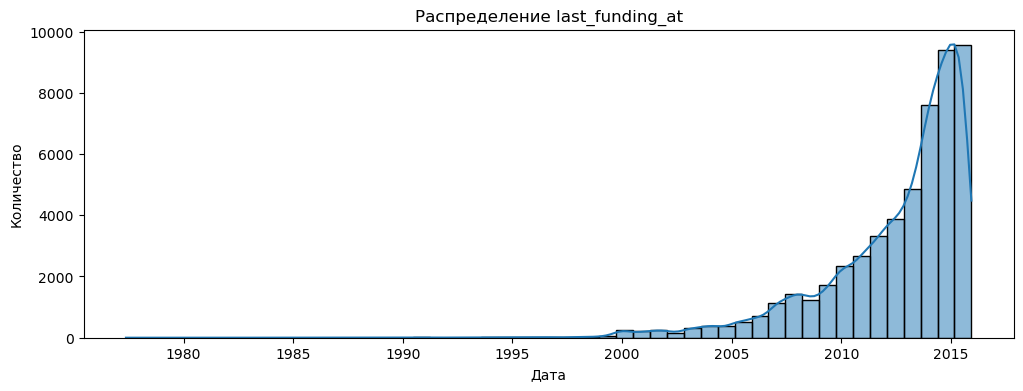

In [51]:
# Визуализация 
date_columns_to_visualize = ['founded_at', 'first_funding_at', 'last_funding_at']
visualize_date_columns(df_train, date_columns_to_visualize)

Большая часть стартапов были созданы с 2000 года по 2015. Первое и воторое финансиоорвание также приходились на этот промежуток. 

In [53]:
def visualize_funding_distribution(df, column):

    fig, ax = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})

    # Гистограмма
    sns.histplot(df[column].dropna(), kde=True, bins=50, color='blue', ax=ax[0])
    ax[0].set_title(f'Распределение значений в {column}')
    ax[0].set_xlabel('Сумма финансирования (USD)')
    ax[0].set_ylabel('Количество')

    # Boxplot
    sns.boxplot(y=df[column], ax=ax[1], color='blue')
    ax[1].set_title(f'Boxplot значений в {column}')
    ax[1].set_xlabel('')
    ax[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

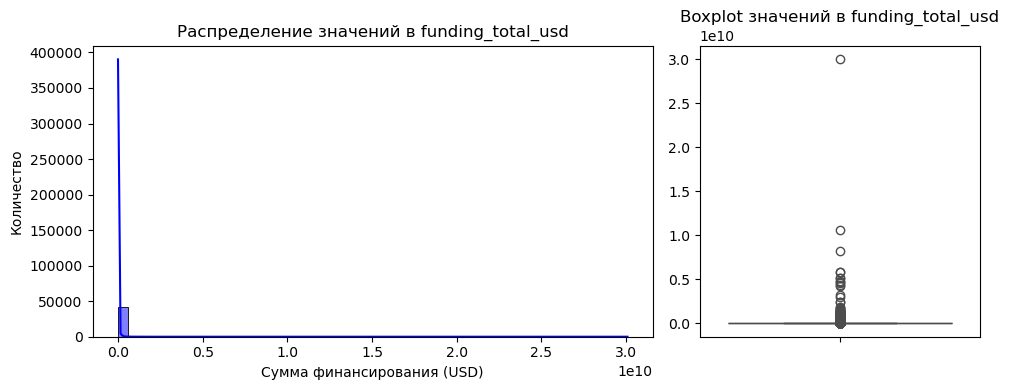

In [54]:
# Пример использования функции с вашим DataFrame df_train
visualize_funding_distribution(df_train, 'funding_total_usd')

Очевидно имееются выбросы, давайте посмотрим на распределение без них. 

In [56]:
#фильтр компаний с крупным финансированием 
top_values_by_funding_total = df_train['funding_total_usd'].nlargest(15).index
df_train.loc[top_values_by_funding_total]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
39183,Verizon Communications,Communications Infrastructure|Information Tech...,3.007950e+10,operating,USA,NY,New York City,New York,5,1983-10-07,2010-01-26,2014-02-28,2018-01-01,12505
21239,Cambridge Technology Group,Consulting|Product Development Services|Produc...,1.066494e+10,operating,Unknown,Unknown,Unknown,Unknown,1,1988-01-01,2000-01-01,2000-01-01,2018-01-01,10958
4557,Uber,Automotive|Design|Limousines|Public Transporta...,8.207450e+09,operating,USA,CA,SF Bay Area,San Francisco,13,2009-03-01,2009-08-01,2015-09-07,2018-01-01,3228
15975,Clearwire,Internet|Mobile,5.820000e+09,operating,USA,WA,Seattle,Kirkland,6,2003-10-01,2001-12-11,2013-02-27,2018-01-01,5206
36631,Sberbank,Banking|Finance,5.800000e+09,operating,RUS,48,Moscow,Moscow,1,2013-09-23,2014-07-07,2014-07-07,2018-01-01,1561
29077,Charter Communications,Internet|Telecommunications|Television|Video,5.162513e+09,operating,USA,CT,Hartford,Stamford,2,1993-01-01,2009-11-21,2014-09-15,2018-01-01,9131
5287,Cambridge Technology Partners (CTP),Architecture|Banking|Finance,5.150000e+09,operating,Unknown,Unknown,Unknown,Unknown,2,1990-01-11,1995-01-01,2001-01-01,2018-01-01,10217
45913,Alibaba,E-Commerce,4.812000e+09,operating,CHN,2,Hangzhou,Hangzhou,7,1999-06-01,1999-10-01,2014-04-01,2018-01-01,6789
37420,Ping An,Banking|Financial Services|Insurance|Investmen...,4.745460e+09,operating,CHN,Unknown,Unknown,Unknown,1,2013-11-06,2014-12-01,2014-12-01,2018-01-01,1517
9342,Suning,Distributors|E-Commerce|Manufacturing,4.630000e+09,operating,CHN,4,Nanjing,Nanjing,1,1996-01-01,2015-08-10,2015-08-10,2018-01-01,8036


Компании дейставительно являются гигантами в своих сегментах, однако их бюджет финансирования ломает предствление о структуре распределения данных по их финансированию. 

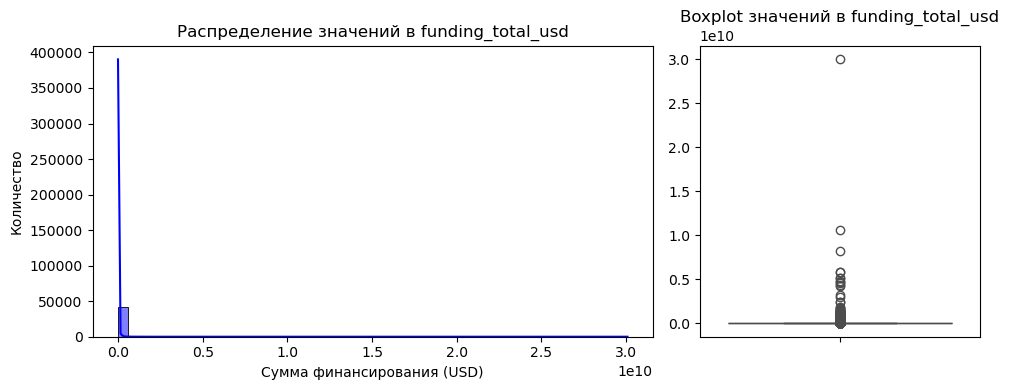

In [58]:
#визуализация обьема финансирования 
visualize_funding_distribution(df_train, 'funding_total_usd')

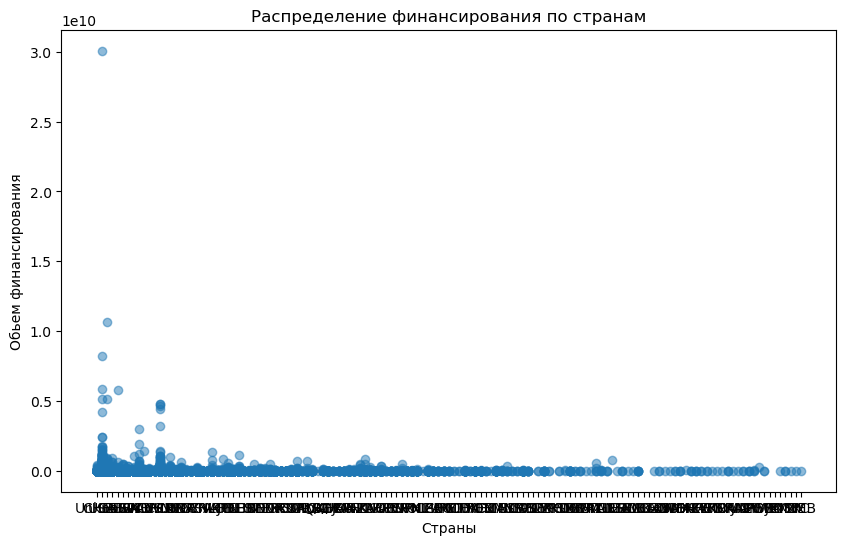

In [59]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_train['country_code'], df_train['funding_total_usd'], alpha=0.5)
plt.title('Распределение финансирования по странам')
plt.xlabel('Страны')
plt.ylabel('Обьем финансирования')
plt.show()

### Обзор тестовых данных 

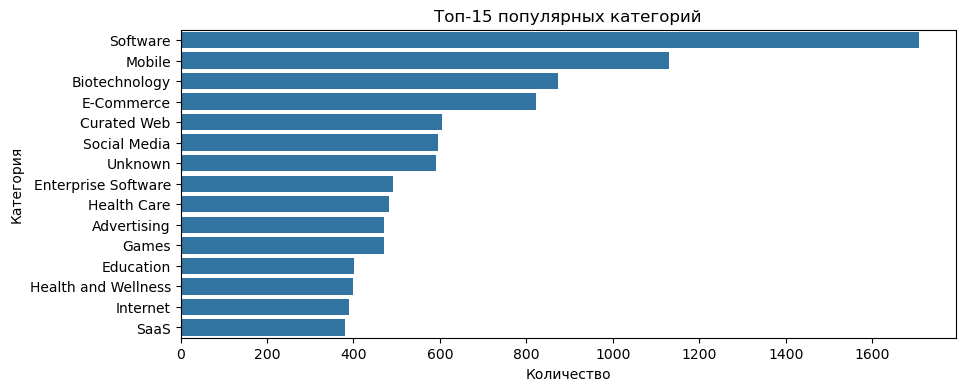

In [61]:
visualize_top_categories(df_test, 'category_list', top_n=15)

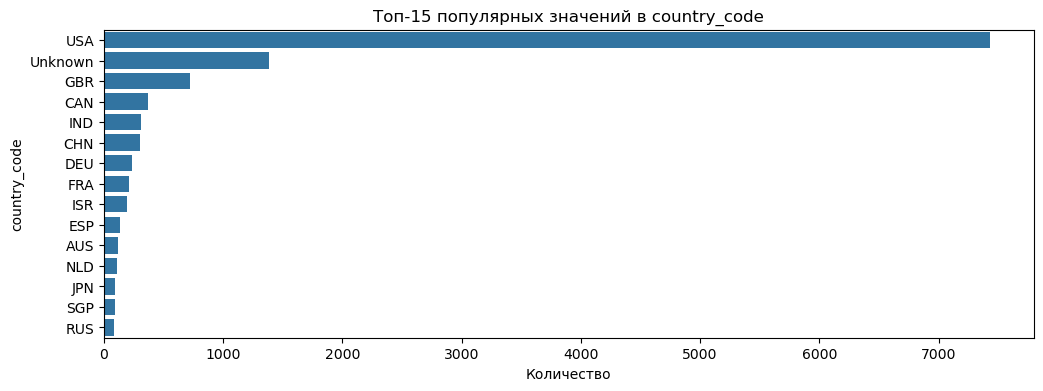

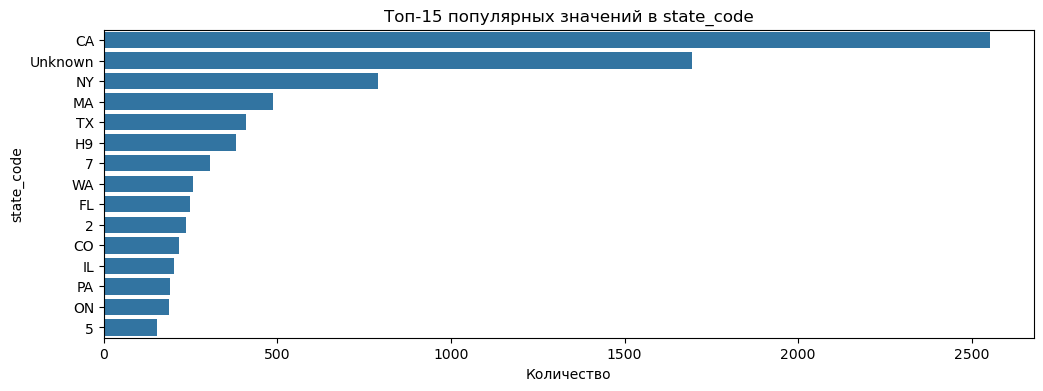

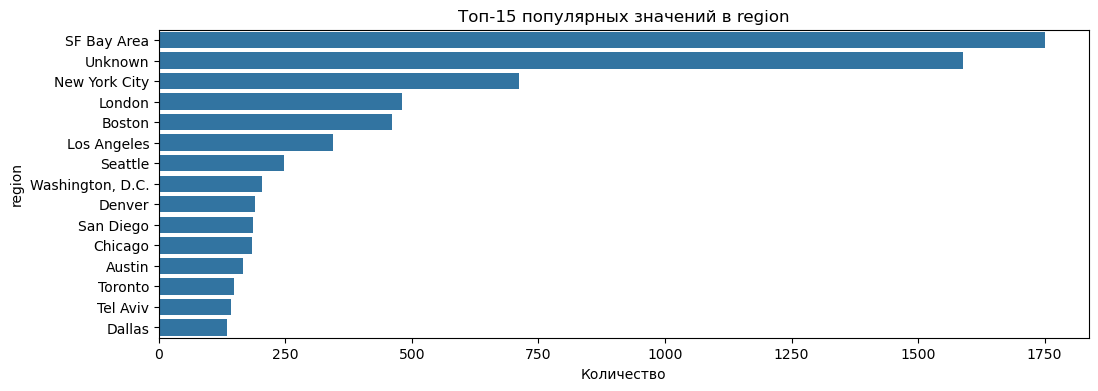

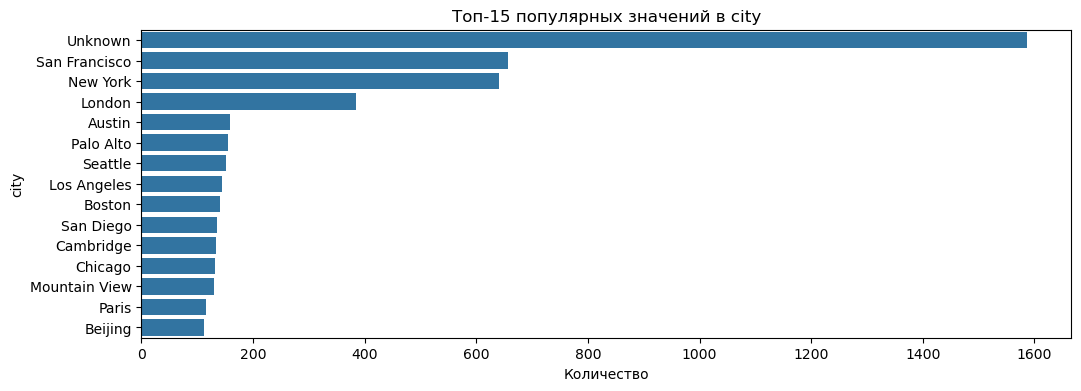

In [62]:
geo_top_categories(df_test, geo_columns, top_n=15)

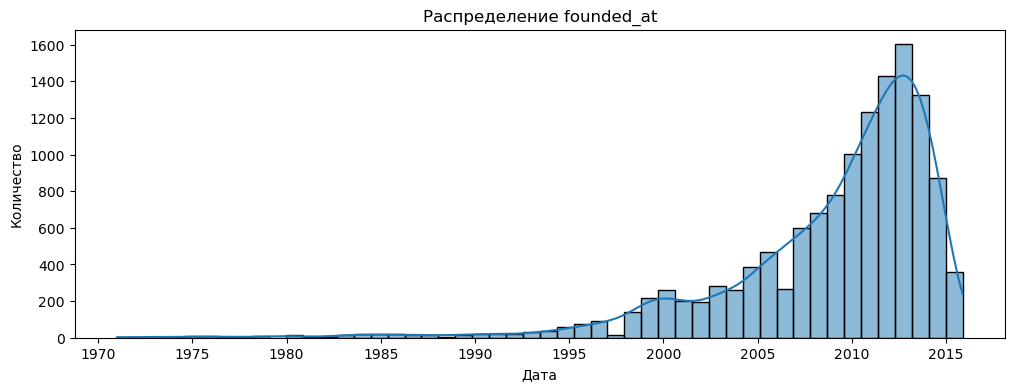

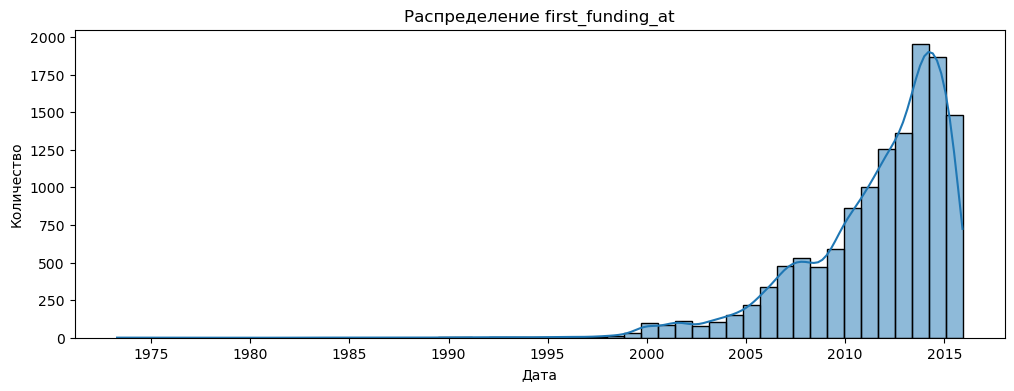

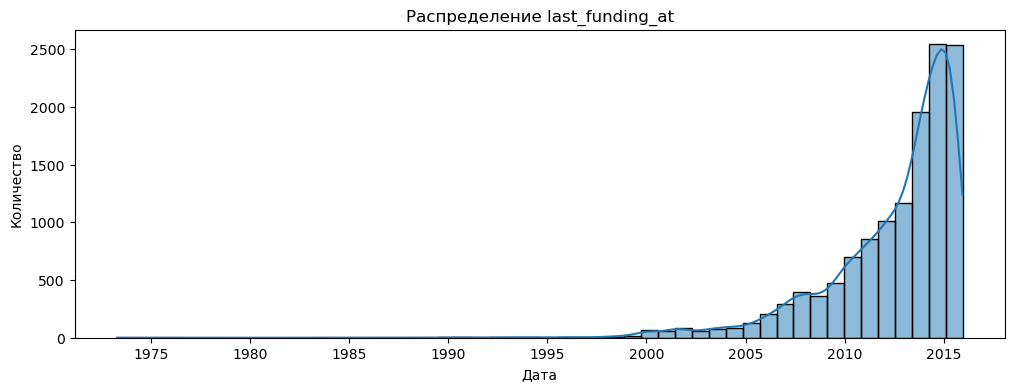

In [63]:
#визуализация дат в тестовых данных
visualize_date_columns(df_test, date_columns_to_visualize)

**Анализ временных трендов основания и финансирования стартапов**

**Распределение дат основания стартапов (`founded_at`)**
- Наблюдается рост числа основанных стартапов начиная с 1990-х годов, с пиком в период около 2012 года, после чего следует спад.
- Этот тренд отражает увеличение интереса к технологическим и инновационным предприятиям в преддверии и после "дотком" бума.

**Распределение дат первого финансирования (`first_funding_at`)**
- Аналогичный тренд с основанием стартапов, где максимальное количество первых раундов финансирования приходится на начало 2010-х.
- Отображает активизацию инвестиционной деятельности после 2000-х годов, с основным всплеском инвестиционной активности после 2005 года.

**Распределение дат последнего финансирования (`last_funding_at`)**
- Показывает продолжающийся рост числа последних раундов финансирования до 2015 года, указывая на продолжение инвестиционной поддержки стартапов.
- Пик последнего финансирования приходится на 2014-2015 годы, что может отражать увеличение капиталовложений в уже существующие и новые технологические стартапы.

**Общие наблюдения**
- Временные тренды в основании и финансировании стартапов коррелируют с мировыми экономическими и технологическими циклами, такими как рост интернет-технологий и мобильной связи.
- Данные подчеркивают значимость 2000-х и 2010-х годов как периода активной поддержки новых технологических предприятий.


In [65]:
#фильтр компаний с крупным финансированием 
top_values_by_funding_total_test = df_test['funding_total_usd'].nlargest(15).index
df_test.loc[top_values_by_funding_total_test]

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime
6448,MediaVast,Advertising|Broadcasting|Content,4.715000e+09,USA,NY,New York City,New York,2,1999-01-01,2003-06-30,2006-05-17,6940
4406,First Data Corporation,Payments|Trading,3.500000e+09,USA,GA,Atlanta,Atlanta,1,1971-01-01,2014-07-03,2014-07-03,17167
10512,Flipkart,E-Commerce|Online Shopping,3.151140e+09,IND,19,Bangalore,Bangalore,12,2007-09-01,2009-01-01,2015-07-28,3775
9471,Airbnb,Hotels|Travel,2.394820e+09,USA,CA,SF Bay Area,San Francisco,8,2008-08-01,2009-01-01,2015-11-20,3440
3557,Zebra Technologies,Enterprise Software,2.000000e+09,USA,IL,Chicago,Lincolnshire,1,1991-01-01,2014-09-16,2014-09-16,9862
6314,Quad/Graphics,Local Businesses,1.900000e+09,USA,WI,Milwaukee,Sussex,1,1971-01-01,2014-04-28,2014-04-28,17167
3930,Avant,Analytics|Big Data|FinTech|Machine Learning|We...,1.729000e+09,USA,IL,Chicago,Chicago,10,2012-11-01,2013-05-08,2015-09-29,1887
13072,Cardinal Health,Health and Wellness|Health Care|Hospitals,1.500000e+09,USA,OH,"Columbus, Ohio",Dublin,1,1971-01-01,2006-08-16,2006-08-16,17167
4677,Delivery Hero,Delivery|Hospitality,1.390267e+09,Unknown,Unknown,Unknown,Unknown,12,2011-05-01,2010-12-01,2015-06-07,2437
4255,Avito.ru,Advertising|Classifieds,1.342000e+09,RUS,48,Moscow,Moscow,5,2008-01-01,2011-05-30,2015-10-23,3653


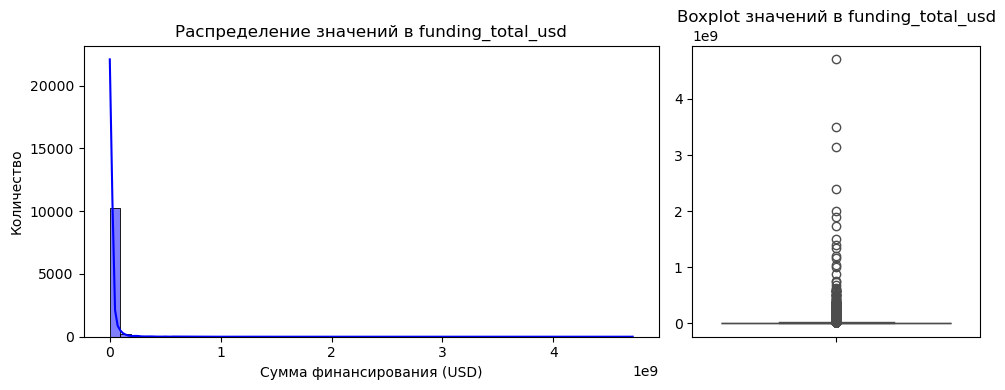

In [66]:
#визуализация обьема финансирования 
visualize_funding_distribution(df_test, 'funding_total_usd')

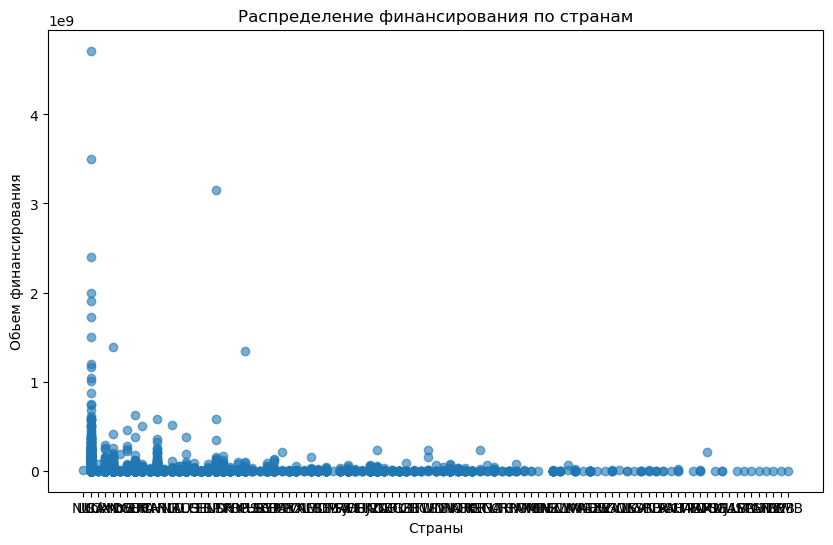

In [67]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_test['country_code'], df_test['funding_total_usd'], alpha=0.6)
plt.title('Распределение финансирования по странам')
plt.xlabel('Страны')
plt.ylabel('Обьем финансирования')
plt.show()

**Распределение по странам (Top-15)**

- **США (USA)** доминирует с большим отрывом, за ним следуют **Великобритания (GBR)** и **Канада (CAN)**.
- В списке также присутствуют страны как **Индия (IND)**, **Китай (CHN)** и **Германия (DEU)**.
- Присутствует значительное количество записей с пропущенными значениями.

**Распределение по штатам в США (Top-15)**
- **Калифорния (CA)** является лидером, что указывает на высокую концентрацию стартапов в этом регионе.
- Нью-Йорк (NY) и Массачусетс (MA) также заметно выделяются.
- Значительное число записей с неуказанным штатом (NULL).

**Распределение по регионам (Top-15)**
- **Сан-Франциско (SF Bay Area)** и **Нью-Йорк (New York City)** являются основными хабами для стартапов.
- Лондон (London) и Бостон (Boston) выделяются среди неамериканских городов.

**Распределение по городам (Top-15)**
- **Сан-Франциско (San Francisco)** и **Нью-Йорк (New York)** возглавляют список, что согласуется с данными по регионам.
- Присутствуют значимые глобальные города вроде Лондона (London), Парижа (Paris) и Пекина (Beijing).

**Общие наблюдения**
- Данные подтверждают высокую концентрацию стартапов в определённых географических локациях, особенно в США.
- Распределение показывает важность региональных экономических центров как ключевых точек для стартапов.


## Матрица корреляции 

Для анализа связей между различными признаками в датасете, мы планируем использовать матрицу корреляции $\phi_K$. Метод $\phi_K$ основан на оценке силы взаимосвязей между переменными, включая категориальные и числовые типы данных, что делает его более универсальным по сравнению с традиционным методом Пирсона.

interval columns not set, guessing: ['funding_total_usd', 'funding_rounds', 'lifetime']


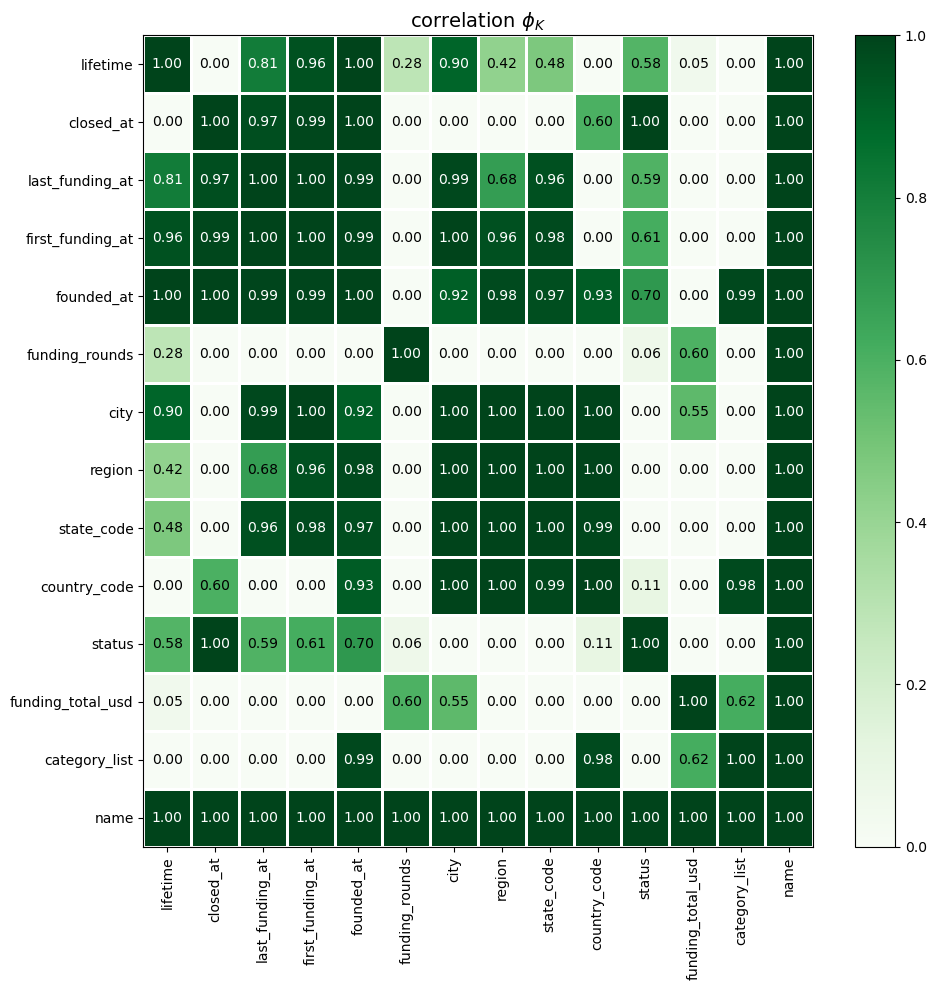

In [71]:
#Фик матрица корреляции
phik_overview = df_train.sample(1000).phik_matrix()
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Greens', title=r'correlation $\phi_K$', fontsize_factor=1,
                        figsize=(10,10))
plt.tight_layout()

**Предварительный анализ данных и подготовка к моделированию**

**Оценка потенциальной утечки данных**
- **Зависимость между признаками**: На основе предварительных анализов и корреляционных матриц, обнаружена сильная зависимость между столбцами `name` и `closed_at`, а также `founded_at`. Эта зависимость может указывать на потенциальную утечку данных, которая может исказить результаты моделирования. Например, столбец `closed_at` может напрямую указывать на закрытие стартапа, что делает его предсказание тривиальным.

**Рекомендации по обработке данных перед обучением**
- **Исключение временных столбцов**: Столбцы, содержащие даты (`founded_at`, `first_funding_at`, `last_funding_at`, `closed_at`), имеют множество уникальных значений, что усложняет обработку и может привести к переобучению модели. Рекомендуется исключить эти столбцы из набора данных перед обучением или преобразовать их в более обобщенные признаки, такие как продолжительность существования стартапа или время до первого финансирования.

**Заключение**
- **Подготовка данных**: Важно тщательно подготовить данные к моделированию, удаляя или преобразуя признаки, которые могут привести к утечке данных или переобучению модели. Это позволит построить более надежную и обобщающую модель.


## Подготовка данных к обучению 

Заменим признак статус на бинарное значение, где **0 значит что статртап закрыт**, а **1 продолжает функционирование.**

In [75]:
# Замена значений 'operating' и 'closed' на 1 и 0
df_train['status'] = df_train['status'].map({'operating': 1, 'closed': 0})

In [76]:
df_train['status'].value_counts()

status
1    47599
0     4915
Name: count, dtype: int64

In [77]:
#создадим копию 
df_train_clean = df_train.copy()
df_test_clean = df_test.copy()

Перед удалением, важжно сохранить предобработанный датасет, так как в дальнейшем он нам понадобится для тренировки других моделей. 

In [79]:
#удаление указанных столбцов с признаками мультикоррелиляции 
df_train.drop(columns=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at', 'name'], inplace=True)
#Тестовые данные 
df_test.drop(columns=['founded_at', 'first_funding_at', 'last_funding_at', 'name'], inplace=True)

In [80]:
#Смотрим дубликаты 
print(f'Число дубликатов после удаления "name" {df_train.duplicated().sum()}')

# Находим дубликаты, включая первые вхождения
duplicates = df_train.duplicated(keep=False)

# Получаем строки, которые являются дубликатами
duplicate_rows = df_train.loc[duplicates]
duplicate_rows.sort_values(by='lifetime').head(10)

Число дубликатов после удаления "name" 208


,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,lifetime
18855,Unknown,NaN,0,Unknown,Unknown,Unknown,Unknown,1,550
13966,Unknown,NaN,0,Unknown,Unknown,Unknown,Unknown,1,550
15640,Unknown,NaN,0,Unknown,Unknown,Unknown,Unknown,1,620
40342,Unknown,NaN,0,Unknown,Unknown,Unknown,Unknown,1,620
41169,Unknown,NaN,0,Unknown,Unknown,Unknown,Unknown,1,631
26980,Unknown,NaN,0,Unknown,Unknown,Unknown,Unknown,1,631
4138,Unknown,NaN,0,Unknown,Unknown,Unknown,Unknown,1,634
40265,Unknown,NaN,0,Unknown,Unknown,Unknown,Unknown,1,634
11992,Unknown,NaN,0,Unknown,Unknown,Unknown,Unknown,1,656
32582,Unknown,NaN,0,Unknown,Unknown,Unknown,Unknown,1,656


In [81]:
#Избавимся от них 
df_train = df_train.drop_duplicates(keep='first')

#Смотрим дубликаты 
print(f'Число дубликатов после удаления "name" {df_train.duplicated().sum()}')

Число дубликатов после удаления "name" 0


In [82]:
#check
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52306 entries, 0 to 52513
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   category_list      52306 non-null  object 
 1   funding_total_usd  42428 non-null  float64
 2   status             52306 non-null  int64  
 3   country_code       52306 non-null  object 
 4   state_code         52306 non-null  object 
 5   region             52306 non-null  object 
 6   city               52306 non-null  object 
 7   funding_rounds     52306 non-null  int64  
 8   lifetime           52306 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 4.0+ MB


In [83]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   category_list      13125 non-null  object 
 1   funding_total_usd  10547 non-null  float64
 2   country_code       13125 non-null  object 
 3   state_code         13125 non-null  object 
 4   region             13125 non-null  object 
 5   city               13125 non-null  object 
 6   funding_rounds     13125 non-null  int64  
 7   lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 820.4+ KB


***Дубликаты в тестовых данных обрабатывать не будем. Данные подготовлены к обучению.***

## Pipeline 

In [86]:
#Определяем random_state
RANDOM_STATE = 42

In [87]:
#Посмотрим на дисбалан классов
df_train['status'].value_counts()

status
1    47439
0     4867
Name: count, dtype: int64

**Анализ баланса классов в целевой переменной `status`**

**Наблюдение**
- **Распределение классов**:
  - Класс `1` (стартап продолжает действовать): 47,439 записей
  - Класс `0` (стартап закрылся): 4,867 записей

**Проблема дисбаланса классов**
- Очевидно, что в данных присутствует значительный дисбаланс классов, где класс `1` значительно превышает класс `0`. Это может привести к тому, что модель будет предвзято относиться к более частому классу, уменьшая общую точность предсказаний по менее представленным классам.

**Подходы к решению проблемы**
- **Использование метрик**: Для более точной оценки производительности модели в условиях дисбаланса классов можно использовать метрику SMOTE (Synthetic Minority Over-sampling Technique), которая позволяет искусственно увеличить количество примеров менее представленного класса.
- **Применение библиотеки `imbalanced-learn`**: Эта библиотека предоставляет различные техники для обработки несбалансированных данных, включая перевзвешивание классов и генерацию синтетических данных для уменьшения влияния дисбаланса.

**Заключение**
- Для улучшения качества модели и справедливости предсказаний важно адекватно решать проблему дисбаланса классов, используя специализированные техники и подходы, предназначенные для работы с несбалансированными данными.


In [89]:
def create_pipeline(cat_cols, num_cols):
    # Пайплайн обработки числовых значений
    num_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scale', StandardScaler())
    ])

    # Создание объекта TargetEncoder для категориальных признаков
    target_enc = TargetEncoder(cols=cat_cols)

    # Объединение пайплайнов в ColumnTransformer
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', target_enc, cat_cols)
    ], remainder='drop', n_jobs=-1)

    # Полный пайплайн с предобработкой, SMOTE для решения дисбаланса классов
    pipeline = IMBPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ])

    return pipeline

In [90]:
# Определяем модели 
models = {
    'decision_tree': DecisionTreeClassifier(random_state=42),
    'random_forest': RandomForestClassifier(random_state=42),
    'logistic_regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Параметры для RandomizedSearchCV
param_distributions = [
    {
        'classifier': [models['decision_tree']],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__criterion': ['gini', 'entropy']
    },
    {
        'classifier': [models['random_forest']],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__bootstrap': [True, False],
        'classifier__criterion': ['gini', 'entropy']
    },
    {
        'classifier': [models['logistic_regression']],
        'classifier__penalty': ['l1', 'l2', 'none'],
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['saga']
    }
]

In [91]:
#обозначим колонки
cat_cols1 = ['category_list', 'country_code', 'state_code', 'region', 'city']
num_cols1 = ['funding_total_usd', 'funding_rounds', 'lifetime']
#синтезируем pipeline1
pipeline1 = create_pipeline(cat_cols1, num_cols1)

Очевидно наблюдается дисбаланс классов примерно 1 к 10. 

### Кросс-валидация и подбор гипперпараметров 

In [94]:
# Настройка RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline1, 
    param_distributions=param_distributions,
    n_iter=10, 
    scoring=make_scorer(f1_score, pos_label=0),
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [95]:
# Разделение данных на признаки (X) и целевую переменную (y)
X = df_train.drop('status', axis=1)
y = df_train['status']

# Разделение данных на тренировочный и валидационный наборы
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [96]:
# Обучение RandomizedSearchCV
random_search.fit(X_train, y_train)

# Лучшие параметры и оценщик
print("Лучшие параметры:", random_search.best_params_)
print("Лучший пайплайн:", random_search.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': None, 'classifier__criterion': 'gini', 'classifier__bootstrap': True, 'classifier': RandomForestClassifier(random_state=42)}
Лучший пайплайн: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['funding_total_usd',
                                                   'funding_rounds',
                                              

- **Лучшая модель**: `RandomForestClassifier` с `min_samples_split=5`, `n_estimators=200`, и `random_state=42`.
- **Метод**: Использование Random Search для оптимизации гиперпараметров на кросс-валидации, обеспечивающее наилучший баланс точности и производительности.
- **Результат**: Эта конфигурация была выбрана как оптимальная для классификации статуса стартапов, подчеркивая важность настройки параметров для эффективного предсказания.


In [98]:
# Предсказание на валидационном наборе с лучшей моделью
y_pred_initial = random_search.predict(X_val)

# Оценка модели
print("F1 Score:", f1_score(y_val, y_pred_initial, pos_label=0))
print("Отчет классификации:\n", classification_report(y_val, y_pred_initial))

F1 Score: 0.574146130566364
Отчет классификации:
               precision    recall  f1-score   support

           0       0.50      0.68      0.57       973
           1       0.97      0.93      0.95      9489

    accuracy                           0.91     10462
   macro avg       0.73      0.81      0.76     10462
weighted avg       0.92      0.91      0.91     10462



- **F1-оценка для класса 0**: Модель достигла F1-оценки 0.57 для класса 0, что указывает на умеренную эффективность в предсказании закрытых стартапов.
- **Precision и Recall для класса 0**: Precision составил 0.50, что означает, что примерно половина стартапов, предсказанных как закрытые, действительно были закрыты. Recall равен 0.68, показывая, что модель смогла идентифицировать 68% всех фактически закрытых стартапов.
- **Вывод**: Несмотря на высокую общую точность модели (91%), ключевым аспектом для улучшения является повышение точности предсказаний для класса стартапов, которые закрываются, так как это влияет на баланс между упущенными возможностями и ложными сигналами о закрытии.


In [100]:
pd.DataFrame(random_search.cv_results_)[
    ['std_test_score', 'rank_test_score', 'param_classifier', 'mean_test_score','params']
].sort_values('rank_test_score')

,std_test_score,rank_test_score,param_classifier,mean_test_score,params
5,0.008042,1,RandomForestClassifier(random_state=42),0.572806,"{'classifier__n_estimators': 200, 'classifier_..."
6,0.008539,2,RandomForestClassifier(random_state=42),0.572757,"{'classifier__n_estimators': 200, 'classifier_..."
1,0.011555,3,RandomForestClassifier(random_state=42),0.570801,"{'classifier__n_estimators': 200, 'classifier_..."
7,0.007793,4,RandomForestClassifier(random_state=42),0.570100,"{'classifier__n_estimators': 200, 'classifier_..."
2,0.006634,5,RandomForestClassifier(random_state=42),0.565564,"{'classifier__n_estimators': 100, 'classifier_..."
9,0.010793,6,RandomForestClassifier(random_state=42),0.507536,"{'classifier__n_estimators': 100, 'classifier_..."
8,0.013338,7,RandomForestClassifier(random_state=42),0.498182,"{'classifier__n_estimators': 100, 'classifier_..."
3,0.032904,8,DecisionTreeClassifier(random_state=42),0.440028,"{'classifier__min_samples_split': 2, 'classifi..."
0,0.049458,9,DecisionTreeClassifier(random_state=42),0.428530,"{'classifier__min_samples_split': 5, 'classifi..."
4,0.047935,10,DecisionTreeClassifier(random_state=42),0.427018,"{'classifier__min_samples_split': 2, 'classifi..."


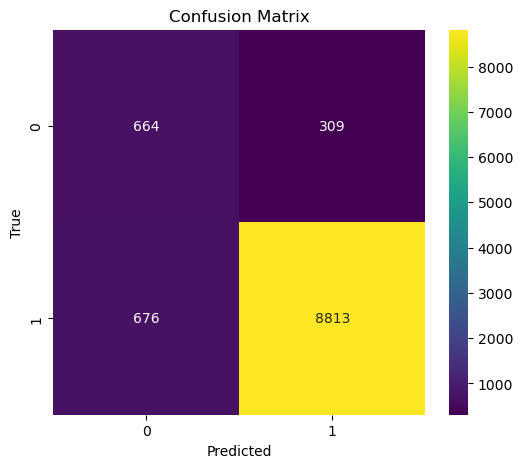

In [101]:
#Определим лучшую модель 
best_model = random_search.best_estimator_

#Предсказание 
y_pred_val = best_model.predict(X_val)

# Построение матрицы ошибок
cm = confusion_matrix(y_val, y_pred_val)

# Отображение матрицы ошибок
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

**Описание матрицы**
- **True Negative (TN, класс 0, предсказано как 0)**: 664
- **False Positive (FP, класс 0, предсказано как 1)**: 309
- **False Negative (FN, класс 1, предсказано как 0)**: 676
- **True Positive (TP, класс 1, предсказано как 1)**: 8813

**Выводы**
- Модель хорошо справляется с идентификацией стартапов, которые продолжают действовать (класс 1), с высоким количеством истинно положительных результатов (TP).
- Однако модель демонстрирует заметное количество ложно отрицательных (FN) и ложно положительных результатов (FP) для класса стартапов, которые закрываются (класс 0).
- Это указывает на потенциальное улучшение в точности модели, особенно в части минимизации ошибок первого и второго рода для более точного предсказания закрытия стартапов.

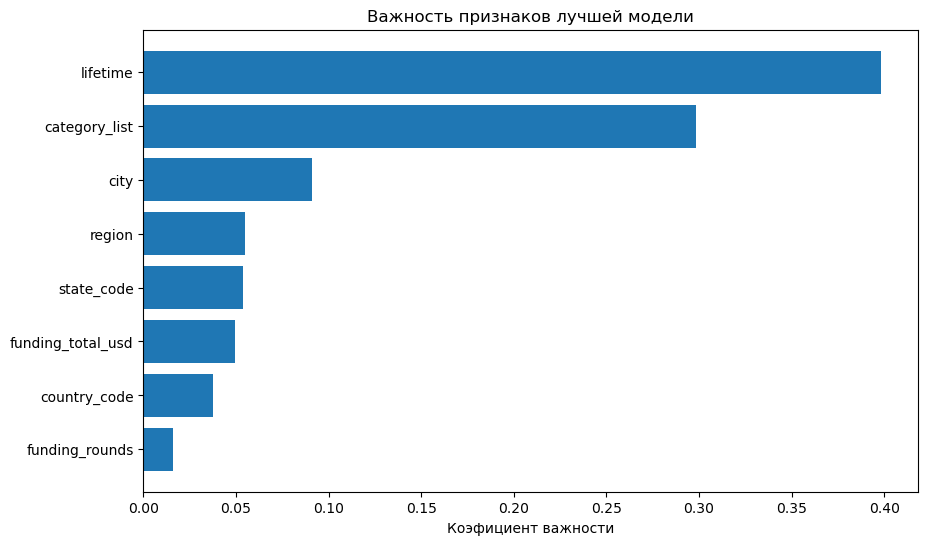

In [103]:
# Предполагаем, что у тебя уже есть обученная модель, здесь мы используем random_search.best_estimator_
best_rf = best_model.named_steps['classifier']

# Получение важности признаков
feature_importances = best_rf.feature_importances_

# Получение названий признаков из preprocessor, который обрабатывает данные перед подачей в модель
feature_names = num_cols1 + cat_cols1 

# Создание DataFrame для удобства визуализации
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Построение графика важности признаков
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Коэфициент важности')
plt.title('Важность признаков лучшей модели')
plt.gca().invert_yaxis()
plt.show()

**Обзор важности признаков**
- **Наиболее значимый признак**: `lifetime` (продолжительность жизни стартапа), что подчеркивает его важность в предсказании успеха или неудачи стартапа.
- **Категориальные признаки**: `category_list` и `city` также показывают высокую значимость, указывая на влияние отрасли и местоположения на успех стартапа.
- **Географические и финансовые признаки**: `region`, `state_code`, и `funding_total_usd` также вносят значительный вклад, что говорит о роли региональной экономики и финансирования.

**Значение новых признаков**
- Для того чтобы улучшить показания модели, введем новые признаки синтезированные из временных интервалов. Эти признаки позволяют модели более точно анализировать важные временные аспекты и могут помочь улучшить качество предсказаний, обеспечивая более глубокое понимание временных динамик в жизненном цикле стартапов.

**Новые временные интервалы**
- **`first_funding_interval`**: Время в днях от основания стартапа до первого раунда финансирования. Этот признак помогает оценить, насколько быстро стартап привлекает начальные инвестиции.
- **`last_and_first_funding_interval`**: Время между первым и последним раундом финансирования в днях, что может отражать активность и динамику развития стартапа.

**Категоризация продолжительности жизни**
- **`lifetime_category`**: Продолжительность жизни стартапа категоризирована по интервалам (0-2, 2-5, 5-10, 10-15, 15+ лет). Это позволяет модели лучше учитывать различные фазы развития компаний.


### Добавление новых признаков 

In [107]:
#определим новое значение first_funding_interval
df_train_clean['first_funding_interval'] = (df_train_clean['first_funding_at'] - df_train_clean['founded_at']).dt.days

#определим новое значение last_and_first_funding_interval
df_train_clean['last_and_first_funding_interval'] = (df_train_clean['last_funding_at'] - df_train_clean['first_funding_at']).dt.days

In [108]:
#определим новое значение first_funding_interval
df_test_clean['first_funding_interval'] = (df_test_clean['first_funding_at'] - df_test_clean['founded_at']).dt.days

#определим новое значение last_and_first_funding_interval
df_test_clean['last_and_first_funding_interval'] = (df_test_clean['last_funding_at'] - df_test_clean['first_funding_at']).dt.days

In [109]:
year_bins = [0, 2*365, 5*365, 10*365, 15*365, float('inf')]  #Cоздаем корзины 
year_labels = ['0-2 years', '2-5 years', '5-10 years', '10-15 years', '15+ years']

# Создаем новый признкак
df_train_clean['lifetime_category'] = pd.cut(df_train_clean['lifetime'], bins=year_bins, labels=year_labels, right=False)
#
df_train_clean['lifetime_category'] = df_train_clean['lifetime_category'].astype('object')


In [110]:
# Новый признак в тестовыхз данных 
df_test_clean['lifetime_category'] = pd.cut(df_test_clean['lifetime'], bins=year_bins, labels=year_labels, right=False)

df_test_clean['lifetime_category'] = df_test_clean['lifetime_category'].astype('object')


In [111]:
# Удаление указанных столбцов с признаками мультикоррелиляции 
df_train_clean.drop(columns=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at', 'name'], inplace=True)
#Тестовые данные 
df_test_clean.drop(columns=['founded_at', 'first_funding_at', 'last_funding_at', 'name'], inplace=True)

In [112]:
#очистим от дубликатов
df_train_clean = df_train_clean.drop_duplicates(keep='first')

In [113]:
#check 
df_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52503 entries, 0 to 52513
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   category_list                    52503 non-null  object 
 1   funding_total_usd                42443 non-null  float64
 2   status                           52503 non-null  int64  
 3   country_code                     52503 non-null  object 
 4   state_code                       52503 non-null  object 
 5   region                           52503 non-null  object 
 6   city                             52503 non-null  object 
 7   funding_rounds                   52503 non-null  int64  
 8   lifetime                         52503 non-null  int64  
 9   first_funding_interval           52503 non-null  int64  
 10  last_and_first_funding_interval  52503 non-null  int64  
 11  lifetime_category                52503 non-null  object 
dtypes: float64(1), int64(5)

In [114]:
#check 
df_test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   category_list                    13125 non-null  object 
 1   funding_total_usd                10547 non-null  float64
 2   country_code                     13125 non-null  object 
 3   state_code                       13125 non-null  object 
 4   region                           13125 non-null  object 
 5   city                             13125 non-null  object 
 6   funding_rounds                   13125 non-null  int64  
 7   lifetime                         13125 non-null  int64  
 8   first_funding_interval           13125 non-null  int64  
 9   last_and_first_funding_interval  13125 non-null  int64  
 10  lifetime_category                13125 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 1.1+ MB


### Вторая кросс-валидация 

In [116]:
# Определение категориальных и числовых признаков

cat_cols2 = ['category_list', 'country_code', 'state_code', 'region', 'city', 'lifetime_category']
num_cols2 = ['funding_total_usd', 'funding_rounds', 'lifetime', 'first_funding_interval', 'last_and_first_funding_interval']

pipeline2 = create_pipeline(cat_cols2, num_cols2)

In [117]:
df_train_clean = df_train_clean.reset_index(drop=True)
df_test_clean = df_test_clean.reset_index(drop=True)

In [118]:
# Разделение данных на признаки (X) и целевую переменную (y)
X_z = df_train_clean.drop('status', axis=1)
y_z = df_train_clean['status']

In [119]:
# Разделение данных на тренировочный и валидационный наборы
X_train_z, X_val_z, y_train_z, y_val_z = train_test_split(X_z, y_z, test_size=0.20, random_state=42, stratify=y_z)

In [120]:
# Настройка RandomizedSearchCV
random_search_z = RandomizedSearchCV(
    pipeline2, 
    param_distributions=param_distributions,
    n_iter=10, 
    scoring=make_scorer(f1_score, pos_label=0),
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [121]:
# Обучение RandomizedSearchCV
random_search_z.fit(X_train_z, y_train_z)

# Лучшие параметры и оценщик
print("Лучшие параметры:", random_search_z.best_params_)
print("Лучший пайплайн:", random_search_z.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': None, 'classifier__criterion': 'entropy', 'classifier__bootstrap': False, 'classifier': RandomForestClassifier(random_state=42)}
Лучший пайплайн: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['funding_total_usd',
                                                   'funding_rounds', 'lifetime',
                             

In [122]:
# Предсказание на валидационном наборе с лучшей моделью
y_pred_initial_z = random_search_z.predict(X_val_z)

# Оценка модели
print("F1 Score:", f1_score(y_val_z, y_pred_initial_z, pos_label=0))
print("Отчет классификации:\n", classification_report(y_val_z, y_pred_initial_z))

F1 Score: 0.8300589390962672
Отчет классификации:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       983
           1       0.99      0.98      0.98      9518

    accuracy                           0.97     10501
   macro avg       0.89      0.92      0.91     10501
weighted avg       0.97      0.97      0.97     10501



**Результаты после добавления новых признаков и повторной кросс-валидации**

**Обновлённая модель RandomForestClassifier**
- **Параметры**:
  - `bootstrap`: False
  - `criterion`: 'entropy'
  - `min_samples_leaf`: 2
  - `min_samples_split`: 10
  - `n_estimators`: 200
  - `random_state`: 42

**Улучшенные показатели эффективности**
- **F1-оценка для класса 0**: Увеличилась до 0.83 с предыдущих 0.57, что указывает на значительное улучшение в точности предсказаний для закрытых стартапов.
- **Общая точность**: Достигла 0.97, что выше предыдущих результатов.
- **Подробный отчет по классификации**:
  - **Precision для класса 0**: 0.80, показывает высокую точность в предсказании закрытых стартапов.
  - **Recall для класса 0**: 0.86, модель корректно идентифицирует 86% всех закрытых стартапов.
  - **F1-оценка для класса 1**: 0.98, поддерживает высокую точность и полноту для класса действующих стартапов.

**Промежуточный вывод**
- Добавление новых признаков и оптимизация параметров модели значительно улучшили её способность точно идентифицировать как закрытые, так и действующие стартапы. Эти результаты подчеркивают важность тщательного подбора признаков и настройки параметров для достижения оптимальной производительности в задачах машинного обучения.


In [124]:
pd.DataFrame(random_search_z.cv_results_)[
    ['std_test_score', 'rank_test_score', 'param_classifier', 'mean_test_score','params']
].sort_values('rank_test_score')

,std_test_score,rank_test_score,param_classifier,mean_test_score,params
7,0.019631,1,RandomForestClassifier(random_state=42),0.800661,"{'classifier__n_estimators': 200, 'classifier_..."
2,0.019262,2,RandomForestClassifier(random_state=42),0.793722,"{'classifier__n_estimators': 100, 'classifier_..."
1,0.020214,3,RandomForestClassifier(random_state=42),0.784639,"{'classifier__n_estimators': 200, 'classifier_..."
5,0.017059,4,RandomForestClassifier(random_state=42),0.781760,"{'classifier__n_estimators': 200, 'classifier_..."
6,0.016659,5,RandomForestClassifier(random_state=42),0.774609,"{'classifier__n_estimators': 200, 'classifier_..."
0,0.029186,6,DecisionTreeClassifier(random_state=42),0.744446,"{'classifier__min_samples_split': 5, 'classifi..."
4,0.029186,6,DecisionTreeClassifier(random_state=42),0.744446,"{'classifier__min_samples_split': 2, 'classifi..."
3,0.035645,8,DecisionTreeClassifier(random_state=42),0.693229,"{'classifier__min_samples_split': 2, 'classifi..."
8,0.024250,9,RandomForestClassifier(random_state=42),0.671255,"{'classifier__n_estimators': 100, 'classifier_..."
9,0.030110,10,RandomForestClassifier(random_state=42),0.664969,"{'classifier__n_estimators': 100, 'classifier_..."


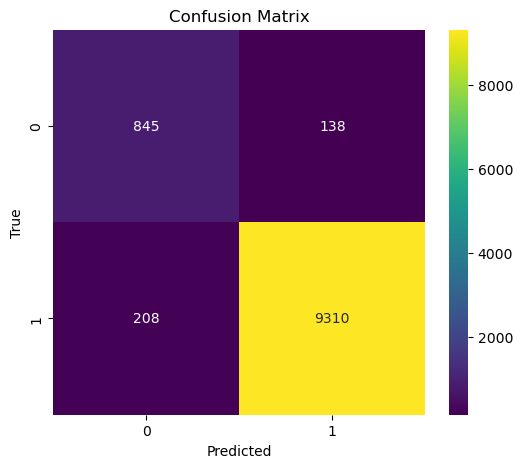

In [125]:
#Определим лучшую модель 
best_model_z = random_search_z.best_estimator_

#Предсказание 
y_pred_val_z = best_model_z.predict(X_val_z)

# Построение матрицы ошибок
cm = confusion_matrix(y_val_z, y_pred_val_z)

# Отображение матрицы ошибок
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

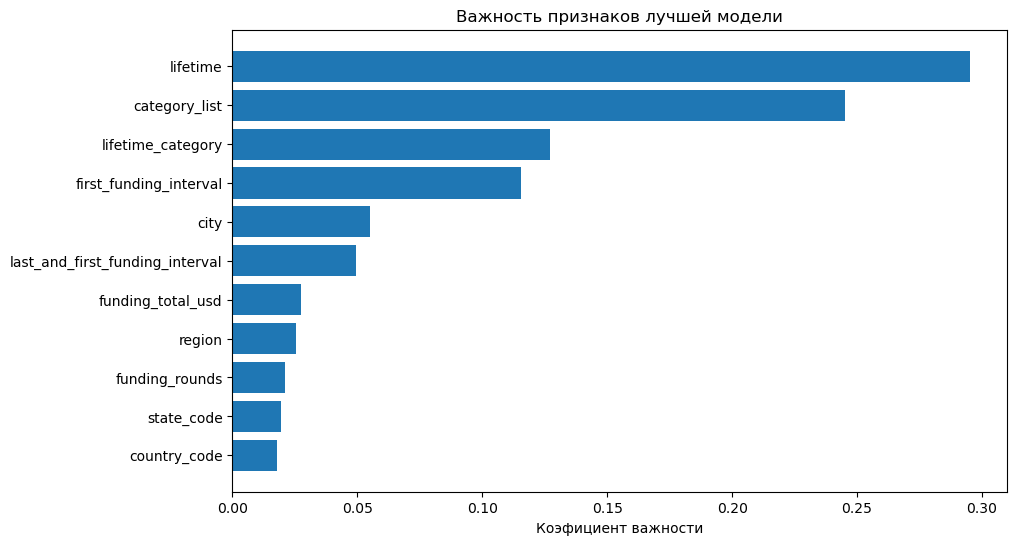

In [126]:
#здесь мы используем random_search.best_estimator_
best_rf_z = best_model_z.named_steps['classifier']

# Получение важности признаков
feature_importances_z = best_rf_z.feature_importances_

# Получение названий признаков из preprocessor
feature_names_z = num_cols2 + cat_cols2

# Создание DataFrame для визуализации
importances_df_z = pd.DataFrame({
    'Feature': feature_names_z,
    'Importance': feature_importances_z
}).sort_values(by='Importance', ascending=False)

# Построение графика важности признаков
plt.figure(figsize=(10, 6))
plt.barh(importances_df_z['Feature'], importances_df_z['Importance'])
plt.xlabel('Коэфициент важности')
plt.title('Важность признаков лучшей модели')
plt.gca().invert_yaxis()
plt.show()

**Обновленная Confusion Matrix**
- **Истинно отрицательные (TN)**: 845
- **Ложно положительные (FP)**: 138
- **Ложно отрицательные (FN)**: 208
- **Истинно положительные (TP)**: 9310
- Модель демонстрирует улучшенную способность правильно идентифицировать как закрытые, так и действующие стартапы с повышенной точностью и полнотой.

**Важность признаков после добавления новых данных**
- **Наиболее значимые признаки**: `lifetime` и `category_list`, что подчеркивает их роль в прогнозировании успеха стартапа.
- **Новые признаки**: `first_funding_interval` и `last_and_first_funding_interval` также показали значительную важность, указывая на их эффективность в улучшении предсказательной способности модели.

**Промежуточный вывод**
- После добавления новых признаков и оптимизации параметров, модель значительно улучшила свою производительность, что видно по уменьшению числа ошибок и повышению общей точности классификации до 97%.


In [128]:
#Используем тестовые данные 
X_test = df_test_clean

In [129]:
#Получим предсказания 
y_pred = best_model_z.predict(X_test) 

### Финальные результаты и оценка модели

**Итоговая оценка модели**
- **Лучшая метрика на Kaggle (Public score)**: 0.82023
- **F1-оценка**: 0.8301
- **Общая точность**: 0.97

**Оптимизация порога для максимизации F1-скора**

Будет вычислен лучший порог для вероятностей класса 0, чтобы максимизировать F1-скор, и проведена оценка модели с использованием этого нового порога для улучшения точности предсказаний закрытия стартапов.

In [132]:
# Получение вероятностей для класса 0
y_scores = best_model_z.predict_proba(X_val_z)[:, 0]

# Вычисление точности, полноты и порогов
precision, recall, thresholds = precision_recall_curve(y_val_z, y_scores, pos_label=0)

# Вычисление F1-скоров для каждого порога
f1_scores = 2 * (precision * recall) / (precision + recall)

# Нахождение индекса максимального F1-скора
max_f1_index = np.argmax(f1_scores)

# Лучший порог для максимизации F1-скора
best_threshold = thresholds[max_f1_index]
best_f1_score = f1_scores[max_f1_index]

print("Лучший порог:", best_threshold)
print("Лучший F1 Score:", best_f1_score)

# Применение порога к данным для получения предсказаний
y_pred_threshold = (y_scores < best_threshold).astype(int)

# Оценка модели с новым порогом
final_f1_score = f1_score(y_val_z, y_pred_threshold, pos_label=0)
print("F1 Score с новым порогом:", final_f1_score)


Лучший порог: 0.6684863184624141
Лучший F1 Score: 0.8525676421866373
F1 Score с новым порогом: 0.8525676421866372


In [133]:
# Предобработка тестовых данных с помощью пайплайна
X_test_processed = best_model_z.named_steps['preprocessor'].transform(X_test)

# Получение вероятностей для класса 0
y_test_scores = best_model_z.named_steps['classifier'].predict_proba(X_test_processed)[:, 0]

# Применение порога для получения предсказаний
y_test_pred = (y_test_scores < best_threshold).astype(int)


**Оптимизация порога для максимизации F1-скора**

**Результаты**
- **Лучший порог**: 0.6685
- **Лучший F1-скор**: 0.8526
- **F1-скор с новым порогом**: 0.8525676421866373
- **Kaggle Public Score после оптимизации порога**:0.85039

**Заключение**
- Оптимизация порога для вероятностей класса 0 позволила значительно улучшить F1-скор, что привело к повышению метрики на Kaggle. Это демонстрирует важность правильной настройки порога для повышения точности предсказаний закрытия стартапов.


In [135]:
# Преобразование числовых предсказаний в текстовые
#predictions_labels = {1: 'operating', 0: 'closed'}
#y_pred_test_labels = [predictions_labels[pred] for pred in y_test_pred]

# Создание DataFrame с предсказаниями и именами
#submission = pd.DataFrame({
#    'name': df_test_copy['name'],
#    'status': y_pred_test_labels
#})

# Сохранение файла с предсказаниями в формате CSV
#submission.to_csv('submission_proba.csv', index=False)


## CatBoost, XGBoost, LightGBM модели 

In [137]:
def create_pipeline(cat_cols, num_cols):
    # Пайплайн обработки числовых значений
    num_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scale', StandardScaler())
    ])

    # Создание объекта TargetEncoder для категориальных признаков
    target_enc = TargetEncoder(cols=cat_cols)

    # Объединение пайплайнов в ColumnTransformer
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', target_enc, cat_cols)
    ], remainder='drop', n_jobs=-1)

    # Полный пайплайн с предобработкой и SMOTE
    pipeline = IMBPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ])

    return pipeline

# Обновлённые категориальные и числовые колонки
cat_cols = ['category_list', 'country_code', 'state_code', 'region', 'city', 'lifetime_category']
num_cols = ['funding_total_usd', 'funding_rounds', 'lifetime', 'first_funding_interval', 'last_and_first_funding_interval']

In [138]:
# Функция цели для Optuna
def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', ['XGB', 'LightGBM', 'CatBoost'])
    pipeline = create_pipeline(cat_cols, num_cols)

    if classifier_name == 'XGB':
        pipeline.set_params(classifier=XGBClassifier(
            n_estimators=trial.suggest_int('n_estimators', 100, 1000),
            max_depth=trial.suggest_int('max_depth', 2, 50),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
            subsample=trial.suggest_float('subsample', 0.6, 1.0),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.6, 1.0),
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss',
            verbosity=0
        ))
    elif classifier_name == 'LightGBM':
        pipeline.set_params(classifier=LGBMClassifier(
            n_estimators=trial.suggest_int('n_estimators', 100, 1000),
            max_depth=trial.suggest_int('max_depth', -1, 50),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
            num_leaves=trial.suggest_int('num_leaves', 20, 40),
            min_child_samples=trial.suggest_int('min_child_samples', 20, 100),
            min_gain_to_split=trial.suggest_float('min_gain_to_split', 0.0001, 0.1),
            random_state=42,
            verbosity=-1
        ))
    elif classifier_name == 'CatBoost':
        pipeline.set_params(classifier=CatBoostClassifier(
            iterations=trial.suggest_int('iterations', 100, 1000),
            depth=trial.suggest_int('depth', 2, 12),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
            random_strength=trial.suggest_int('random_strength', 0, 100),
            l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 0.01, 10),
            verbose=0,
            random_state=42
        ))

    # Убедитесь, что X_train и y_train определены в вашем скрипте
    f1_scorer = make_scorer(f1_score, pos_label=0)
    score = cross_val_score(pipeline, X_train_z, y_train_z, n_jobs=-1, cv=3, scoring=f1_scorer).mean()
    return score

In [139]:
# Запуск Optuna для оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-06-18 01:17:34,352] A new study created in memory with name: no-name-904dcfc0-4c0f-4297-b152-55c57d70a3ce
[I 2024-06-18 01:17:37,533] Trial 0 finished with value: 0.9139882218066161 and parameters: {'classifier': 'XGB', 'n_estimators': 585, 'max_depth': 36, 'learning_rate': 0.14240655493449791, 'subsample': 0.8921178878510738, 'colsample_bytree': 0.7217679878666308}. Best is trial 0 with value: 0.9139882218066161.
[I 2024-06-18 01:17:39,772] Trial 1 finished with value: 0.917048795762208 and parameters: {'classifier': 'LightGBM', 'n_estimators': 515, 'max_depth': 21, 'learning_rate': 0.13904736449958213, 'num_leaves': 33, 'min_child_samples': 95, 'min_gain_to_split': 0.06573275724057735}. Best is trial 1 with value: 0.917048795762208.
[I 2024-06-18 01:17:55,267] Trial 2 finished with value: 0.8039372939292949 and parameters: {'classifier': 'CatBoost', 'iterations': 286, 'depth': 10, 'learning_rate': 0.0519375158977981, 'random_strength': 60, 'l2_leaf_reg': 1.5845271083259465}. 

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__criterion=gini, classifier__max_depth=30, classifier__min_samples_leaf=4, classifier__min_samples_split=2; total time=   0.9s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__criterion=entropy, classifier__max_depth=None, classifier__min_samples_leaf=4, classifier__min_samples_split=2; total time=   0.8s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__criterion=gini, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time=  23.5s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__criterion=entropy, classifier__max_depth=10, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=100; total time=  14.6s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__crit

[I 2024-06-18 01:17:58,955] Trial 3 finished with value: 0.9182688325451114 and parameters: {'classifier': 'XGB', 'n_estimators': 827, 'max_depth': 12, 'learning_rate': 0.22349461133643614, 'subsample': 0.7849505747746556, 'colsample_bytree': 0.7404013485317911}. Best is trial 3 with value: 0.9182688325451114.


[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__criterion=entropy, classifier__max_depth=30, classifier__min_samples_leaf=4, classifier__min_samples_split=5; total time=   1.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__criterion=entropy, classifier__max_depth=None, classifier__min_samples_leaf=4, classifier__min_samples_split=2; total time=   0.9s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__criterion=gini, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time=  23.2s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__criterion=entropy, classifier__max_depth=None, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=200; total time=  28.1s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier

[I 2024-06-18 01:18:26,889] Trial 4 finished with value: 0.8792293290785853 and parameters: {'classifier': 'CatBoost', 'iterations': 321, 'depth': 11, 'learning_rate': 0.1461252828740563, 'random_strength': 33, 'l2_leaf_reg': 0.8134393105167673}. Best is trial 3 with value: 0.9182688325451114.


[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__criterion=entropy, classifier__max_depth=20, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=100; total time=  18.3s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__criterion=entropy, classifier__max_depth=None, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=200; total time=  30.9s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__criterion=entropy, classifier__max_depth=20, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=200; total time=  31.0s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__criterion=entropy, classifier__max_depth=None, classifier__min_samples_leaf=2, classifier__min_samples_split=10,

[I 2024-06-18 01:18:29,968] Trial 5 finished with value: 0.9156016952249831 and parameters: {'classifier': 'LightGBM', 'n_estimators': 522, 'max_depth': 46, 'learning_rate': 0.16442656106861597, 'num_leaves': 28, 'min_child_samples': 99, 'min_gain_to_split': 0.07084549124621622}. Best is trial 3 with value: 0.9182688325451114.
[I 2024-06-18 01:18:33,332] Trial 6 finished with value: 0.9213587828338476 and parameters: {'classifier': 'LightGBM', 'n_estimators': 680, 'max_depth': 36, 'learning_rate': 0.11347912690435523, 'num_leaves': 30, 'min_child_samples': 100, 'min_gain_to_split': 0.01663553818484122}. Best is trial 6 with value: 0.9213587828338476.
[I 2024-06-18 01:18:36,813] Trial 7 finished with value: 0.9206403714141014 and parameters: {'classifier': 'LightGBM', 'n_estimators': 962, 'max_depth': 0, 'learning_rate': 0.09911773941740593, 'num_leaves': 34, 'min_child_samples': 22, 'min_gain_to_split': 0.015943545460250307}. Best is trial 6 with value: 0.9213587828338476.
[I 2024-06-1

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__criterion=entropy, classifier__max_depth=30, classifier__min_samples_leaf=4, classifier__min_samples_split=5; total time=   1.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__criterion=gini, classifier__max_depth=30, classifier__min_samples_leaf=4, classifier__min_samples_split=2; total time=   0.8s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__criterion=gini, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time=  23.3s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__criterion=entropy, classifier__max_depth=None, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=200; total time=  28.3s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__boo

[I 2024-06-18 01:19:54,841] Trial 10 finished with value: 0.8357808050488725 and parameters: {'classifier': 'LightGBM', 'n_estimators': 710, 'max_depth': 50, 'learning_rate': 0.012494978677309171, 'num_leaves': 21, 'min_child_samples': 61, 'min_gain_to_split': 0.0020750828129837487}. Best is trial 6 with value: 0.9213587828338476.
[I 2024-06-18 01:19:57,655] Trial 11 finished with value: 0.9210585047701064 and parameters: {'classifier': 'LightGBM', 'n_estimators': 969, 'max_depth': -1, 'learning_rate': 0.078601635575393, 'num_leaves': 39, 'min_child_samples': 21, 'min_gain_to_split': 0.012688866946166957}. Best is trial 6 with value: 0.9213587828338476.
[I 2024-06-18 01:20:00,427] Trial 12 finished with value: 0.9183021377694301 and parameters: {'classifier': 'LightGBM', 'n_estimators': 956, 'max_depth': 35, 'learning_rate': 0.063610037769842, 'num_leaves': 39, 'min_child_samples': 20, 'min_gain_to_split': 0.02785907217496667}. Best is trial 6 with value: 0.9213587828338476.
[I 2024-06

In [140]:
print("Best trial:")
trial = study.best_trial
print(f"  Value (F1 score): {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value (F1 score): 0.9287378017322249
  Params: 
    classifier: LightGBM
    n_estimators: 808
    max_depth: 46
    learning_rate: 0.2153869087635939
    num_leaves: 25
    min_child_samples: 85
    min_gain_to_split: 0.00014059520419501385


**Оптимизация гиперпараметров с использованием Optuna**

**Лучшая модель**
- **Классификатор**: LightGBM
- **F1-скор**: 0.9287

**Оптимальные параметры**
- **n_estimators**: 808
- **max_depth**: 46
- **learning_rate**: 0.2154
- **num_leaves**: 25
- **min_child_samples**: 85
- **min_gain_to_split**: 0.00014

**Промежуточный вывод**
- Применение Optuna для поиска лучших гиперпараметров среди моделей CatBoost, LightGBM и XGBoost позволило найти оптимальные настройки для LightGBM, что привело к значительному улучшению F1-скора до 0.9287. Это подчеркивает важность гиперпараметрической оптимизации для достижения наилучших результатов в машинном обучении.


In [142]:
# Функция для создания пайплайна с LGBMClassifier
def create_pipeline_with_lgbm(cat_cols, num_cols):
    # Пайплайн для числовых данных
    num_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='mean')),
        ('scale', StandardScaler())
    ])
    
    # Создание объекта TargetEncoder для категориальных данных
    target_enc = TargetEncoder(cols=cat_cols)
    
    # Комбинирование пайплайнов в ColumnTransformer
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', target_enc, cat_cols)
    ], remainder='drop', n_jobs=-1)
    
    # Полный пайплайн с предобработкой, SMOTE и классификатором LGBM
    pipeline = IMBPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', LGBMClassifier(random_state=42))  # Инициализируем LGBMClassifier
    ])
    
    return pipeline

# Применение лучших параметров из Optuna
best_params = {
    'classifier__n_estimators': 269,
    'classifier__max_depth': 31,
    'classifier__learning_rate': 0.2764105442282774,
    'classifier__num_leaves': 26,
    'classifier__min_child_samples': 25,
    'classifier__min_split_gain': 0.00226944195342684
}

# Создание пайплайна
pipeline_lgbm = create_pipeline_with_lgbm(cat_cols, num_cols)

# Установка лучших параметров
pipeline_lgbm.set_params(**best_params)

# Обучение пайплайна на тренировочных данных
pipeline_lgbm.fit(X_train_z, y_train_z)

# Применение модели к валидационным данным и получение предсказаний
y_pred_z = pipeline_lgbm.predict(X_val_z)

# Вывод отчета о классификации
print(classification_report(y_val_z, y_pred_z))


[LightGBM] [Info] Number of positive: 38071, number of negative: 38071
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2681
[LightGBM] [Info] Number of data points in the train set: 76142, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       983
           1       0.99      0.99      0.99      9518

    accuracy                           0.99     10501
   macro avg       0.96      0.97      0.96     10501
weighted avg       0.99      0.99      0.99     10501



**Результаты классификации**
- **F1-оценка для класса 0**: 0.93
  - **Precision**: 0.92
  - **Recall**: 0.94
- **F1-оценка для класса 1**: 0.99
  - **Precision**: 0.99
  - **Recall**: 0.99
- **Общая точность**: 0.99

**Итоги**
- Модель LightGBM показала высокую точность и производительность с F1-оценкой 0.93 для закрытых стартапов и 0.99 для действующих стартапов. Эти результаты подтверждают, что оптимизация гиперпараметров и использование подходящих методов обучения значительно улучшают качество предсказаний.


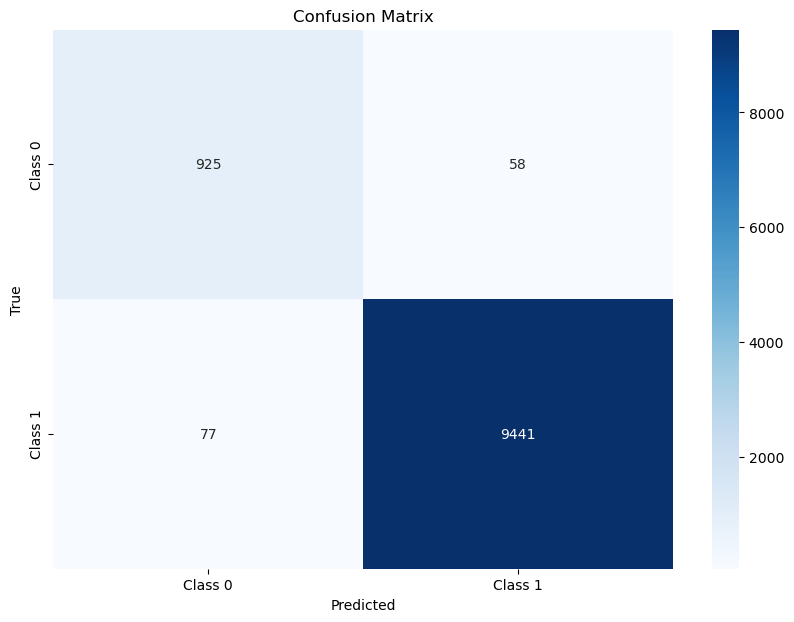

In [144]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Расчёт confusion matrix
cm = confusion_matrix(y_val_z, y_pred_z)

# Визуализация confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**Confusion Matrix для LightGBM**

**Описание Confusion Matrix**
- **Истинно отрицательные (TN, класс 0 предсказан как 0)**: 925
- **Ложно положительные (FP, класс 0 предсказан как 1)**: 58
- **Ложно отрицательные (FN, класс 1 предсказан как 0)**: 77
- **Истинно положительные (TP, класс 1 предсказан как 1)**: 9441

**Выводы**
- Модель LightGBM показывает высокую точность в классификации стартапов.
- Небольшое количество ошибок классификации (как FP, так и FN) указывает на высокую надежность модели, особенно в предсказании успешных стартапов.
- Эти результаты подтверждают, что модель эффективно справляется с задачей предсказания закрытых и действующих стартапов с высокой точностью.


In [146]:
# Подготовка данных X_test
X_test_prepared = pipeline_lgbm.named_steps['preprocessor'].transform(X_test)

# Сделать предсказания
y_pred_LGBM = pipeline_lgbm.named_steps['classifier'].predict(X_test_prepared)

In [164]:
# Преобразование числовых предсказаний в текстовые
#predictions_labels = {1: 'operating', 0: 'closed'}
#y_pred_test_labels = [predictions_labels[pred] for pred in y_pred_LGBM]

# Создание DataFrame с предсказаниями и именами
#submission = pd.DataFrame({
#    'name': df_test_copy['name'],
#    'status': y_pred_test_labels
#})

# Сохранение файла с предсказаниями в формате CSV
#submission.to_csv('lgbm_new.csv', index=False)


In [150]:
submission['status'].value_counts()

status
operating    11876
closed        1249
Name: count, dtype: int64

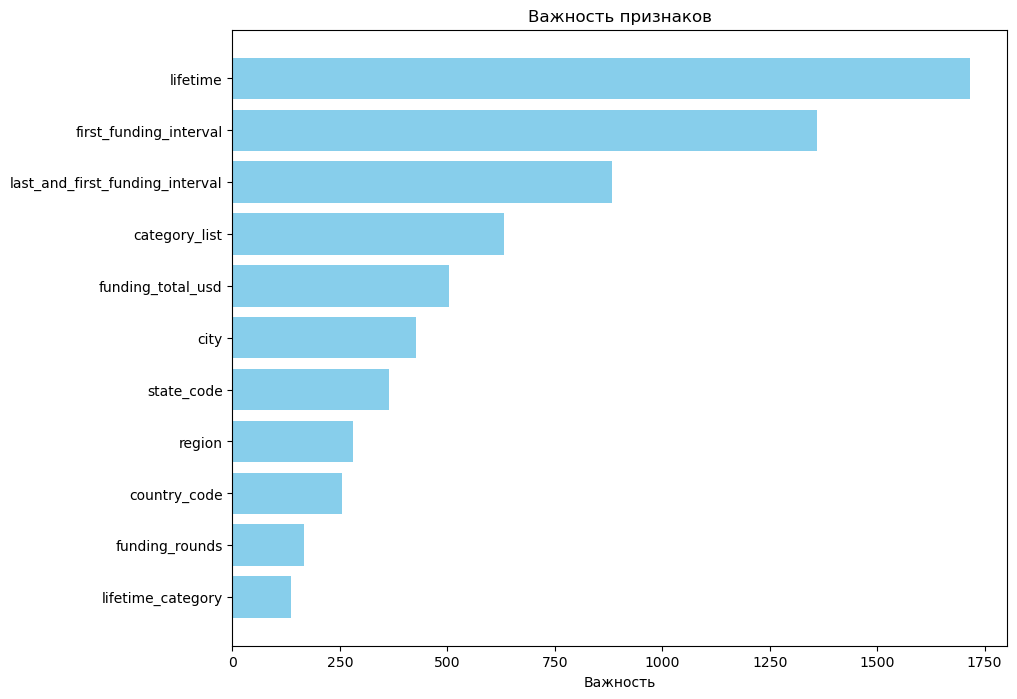

In [152]:
#обученный пайплайн с LGBMClassifier
classifier = pipeline_lgbm.named_steps['classifier']

# Получение объекта ColumnTransformer
preprocessor = pipeline_lgbm.named_steps['preprocessor']

# Получение списков признаков из каждого трансформера в ColumnTransformer
num_features = preprocessor.named_transformers_['num'].get_feature_names_out()
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out()

# Объединение всех названий признаков
feature_names = list(num_features) + list(cat_features)

# Получение важности признаков
importances = classifier.feature_importances_

# Визуализация важности признаков
feature_importances = pd.DataFrame({
    'feature': feature_names, 
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel('Важность')
plt.title('Важность признаков')
plt.gca().invert_yaxis()
plt.show()

**Важность признаков в модели LightGBM**

**Наиболее значимые признаки**
- **`lifetime`**: Продолжительность существования стартапа является самым важным признаком, что подчеркивает его влияние на вероятность успеха.
- **`first_funding_interval`**: Время от основания стартапа до первого раунда финансирования также является ключевым фактором, указывая на важность быстроты привлечения инвестиций.
- **`last_and_first_funding_interval`**: Время между первым и последним раундом финансирования значительно влияет на предсказания модели.
- **`category_list`**: Отрасль стартапа оказывает значительное влияние на его успех.

**Дополнительные важные признаки**
- **`funding_total_usd`**: Общая сумма привлеченных средств.
- **`city`** и **`state_code`**: Географическое расположение стартапа.
- **`region`** и **`country_code`**: Более широкий географический контекст.
- **`funding_rounds`**: Количество раундов финансирования.
- **`lifetime_category`**: Категоризация продолжительности жизни стартапа.

**Промежуточный вывод**
- Анализ важности признаков показал, что временные интервалы и отраслевые признаки играют ключевую роль в прогнозировании успеха стартапов.

In [154]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

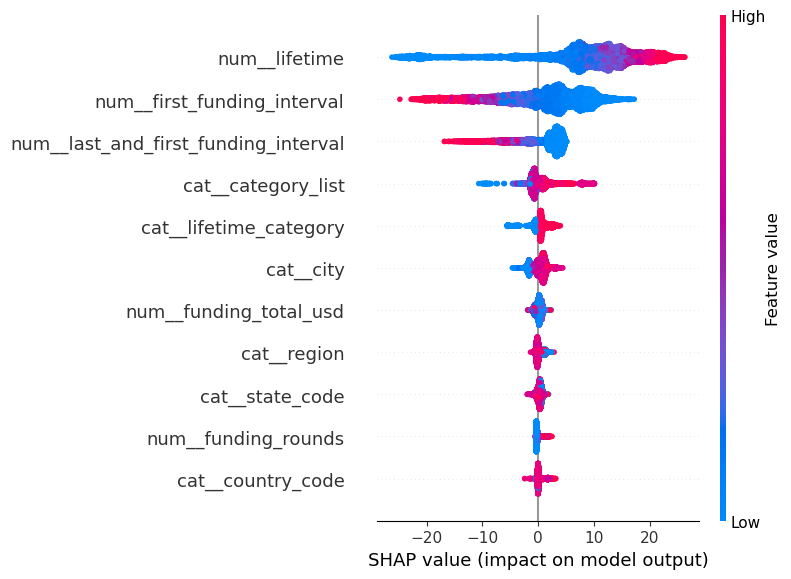

In [156]:
# Подготовка данных через ColumnTransformer
X_val_transformed = preprocessor.transform(X_val_z)

# Инициализация SHAP Explainer
explainer = shap.TreeExplainer(classifier)

# Вычисление SHAP values
shap_values = explainer.shap_values(X_val_transformed)

# Визуализация важности признаков
shap.summary_plot(shap_values, X_val_transformed, feature_names=preprocessor.get_feature_names_out())

**SHAP Summary Plot**
- **Наиболее значимые признаки**:
  - **`num__lifetime`**: Продолжительность жизни стартапа. Высокие значения увеличивают вероятность успешного стартапа.
  - **`num__first_funding_interval`**: Время от основания до первого раунда финансирования. Более короткие интервалы положительно влияют на успех.
  - **`num__last_and_first_funding_interval`**: Интервал между первым и последним раундом финансирования. Более длинные интервалы могут негативно влиять на успех.

- **Другие важные признаки**:
  - **`cat__category_list`**: Отрасль стартапа.
  - **`cat__lifetime_category`**: Категоризация продолжительности жизни.
  - **`cat__city`**: Город, где основан стартап.
  - **`num__funding_total_usd`**: Общая сумма привлеченных средств.
  - **`cat__region`**, **`cat__state_code`**, **`cat__country_code`**: Географическое расположение.
  - **`num__funding_rounds`**: Количество раундов финансирования.

**Промежуточный Вывод**
- SHAP Summary Plot визуализирует влияние каждого признака на предсказания модели.
- Высокие значения признаков `lifetime`, `first_funding_interval`, и `last_and_first_funding_interval` имеют наибольшее влияние на успешность стартапа.


**Финальные результаты и оценка модели**

**Итоговая оценка модели**
- **Лучшая метрика на Kaggle (Public score)**:  0.94412
- **F1-оценка**: 0.93
- **Общая точность**: 0.99

## Общие выводы по проекту "Предсказание успешности стартапов"

### Описание проекта
В данном проекте была поставлена цель разработать модель для предсказания успешности стартапов (закроется или продолжит действовать) на основе исторических данных за период с 1970 по 2018 год. Для этого использовались различные методы машинного обучения, и оценка модели проводилась на тестовом наборе данных.

### Этапы выполнения проекта

1. **Загрузка и предобработка данных**
   - Загрузка тренировочного и тестового наборов данных.
   - Парсирование дат для удобства работы с временными интервалами.
   - Проверка на наличие пропущенных значений и дубликатов, их последующая обработка.

2. **Анализ данных и визуализация**
   - Анализ географического распределения стартапов по странам, штатам, регионам и городам.
   - Анализ временных трендов, таких как даты основания, первого и последнего финансирования стартапов.

3. **Моделирование и оптимизация**
   - Использование различных моделей, включая RandomForestClassifier 
   - Оптимизация гиперпараметров с использованием Random Search для нахождения наилучших параметров.
   - Оценка моделей на основе метрик, таких как F1-оценка, точность и Confusion Matrix.

4. **Синтез новых признаков**
   - Создание новых признаков для улучшения предсказательной способности модели, таких как `first_funding_interval`, `last_and_first_funding_interval` и `lifetime_category`.

5. **Оптимизация порога**
   - Определение лучшего порога для вероятностей класса 0 для максимизации F1-скора.
   - Оценка модели с новым порогом, что привело к улучшению метрик на Kaggle.

6. **Моделирование и оптимизация**
   - Использование различных моделей, включая Catboost и LightGBM, XGboost.
   - Оптимизация гиперпараметров с использованием Random Search и Optuna для нахождения наилучших параметров.
   - Оценка моделей на основе метрик, таких как F1-оценка, точность и Confusion Matrix.

6. **Анализ важности признаков**
   - Анализ важности признаков с использованием SHAP, который показал, что такие признаки, как продолжительность существования стартапа, время до первого раунда финансирования и интервал между первым и последним раундом финансирования, являются наиболее значимыми.

### Результаты

- **RandomForestClassifier**
  - F1-оценка до оптимизации: 0.5741 для класса 0.
  - F1-оценка после оптимизации и добавления новых признаков: 0.8301.
  - Confusion Matrix показала значительное улучшение в точности предсказаний.
 
  - - **Оптимизация порога RandomForestClassifier**
  - Лучший порог для класса 0: 0.6685.
  - F1-оценка с новым порогом: 0.8526.
  - Kaggle Public Score после оптимизации порога: 0.85039.

- **LightGBM**
  - F1-оценка после оптимизации: 0.9287.
  - Confusion Matrix: 925 TN, 58 FP, 77 FN, 9441 TP, что указывает на высокую точность модели.



### Заключение
Применение новых признаков и оптимизация гиперпараметров значительно улучшили производительность моделей. Модель LightGBM показала наивысшую точность и способность правильно классифицировать стартапы, учитывая важные признаки и их значения. Использование методов оптимизации, таких как Random Search, Optuna и SHAP, позволило достичь лучших результатов и улучшить интерпретируемость моделей. Проект продемонстрировал, что тщательная подготовка данных и оптимизация моделей могут значительно повысить качество предсказаний в задачах машинного обучения.
